# Task 4: Link Prediction on MetaFam Knowledge Graph

This notebook implements link prediction using:
- **4 KGE Models**: TransE, DistMult, ComplEx, RotatE
- **2 GNN Models**: RGCN + DistMult, RGCN + RotatE

## Data Splitting Strategies

1. **Naive Random (Type 1)**: Simple random split. Vocabulary built only from training set (inductive risk).
2. **Transductive (Type 2)**: Random split with shared vocabulary from train + valid.
3. **Inverse Leakage Removal (Type 3)**: Groups inverse relation pairs and splits by groups.

## Evaluation
- **Metrics**: MRR (Mean Reciprocal Rank), Hits@1, Hits@10
- **Filtered Evaluation**: Filter out other true triples when ranking
- **Test Set**: External test.txt (never used for training or vocabulary)

## 1. Setup and Imports

**For VS Code with Google Colab Extension:**

1. When selecting kernel, choose **GPU** option (you already did this ✅)
2. Make sure `Precog_task_graphs` folder is in Google Drive (My Drive)
3. Run Cell 3 (Colab Setup) - mounts Drive and changes to project directory
4. Run Cell 4 (Imports) - verifies GPU and imports modules
5. Continue with remaining cells

In [3]:
# ==== COLAB SETUP (Run this cell first!) ====
# For Google Colab with Drive mounted:

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Change to project directory
# IMPORTANT: Update this path if your folder is in a different location
%cd /content/drive/MyDrive/Precog_task_graphs

# Step 3: Verify the folder structure
!ls -la
!ls src/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Precog_task_graphs
total 85
-rw------- 1 root root  4946 Feb  8 21:45 assignment2.md
-rw------- 1 root root  4830 Feb  9 09:28 assignment3.md
-rw------- 1 root root  5169 Feb  9 10:59 assignment4.md
-rw------- 1 root root  5013 Feb  8 17:14 assignment.md
drwx------ 3 root root  4096 Feb  9 15:01 data
drwx------ 2 root root  4096 Feb  9 15:01 .git
-rw------- 1 root root   215 Feb  9 13:27 insights.txt
drwx------ 2 root root  4096 Feb  9 15:01 notebooks
drwx------ 3 root root  4096 Feb  9 15:48 outputs
-rw------- 1 root root     0 Feb  8 16:36 README.md
-rw------- 1 root root   242 Feb  8 22:59 requirements.txt
-rw------- 1 root root 44386 Feb  9 14:56 skill.md
drwx------ 3 root root  4096 Feb  9 15:01 src
communities.py	gnn_models.py  proximity.py  splitting.py
data_loader.py	__init__.py    __pycache__   train_eval.py
exploration.py	kge_

In [4]:
# ==== IMPORTS (Run this cell after mounting Drive!) ====
import sys
import os
import inspect
import warnings
warnings.filterwarnings('ignore')

# Add src to path (using absolute path from current directory)
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)
print(f"Added to path: {src_path}")

# ==== GPU CHECK ====
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Using device: {device}")

# Custom modules
from splitting import load_triples, generate_splits, SplitResult
from kge_models import create_kge_model
from gnn_models import create_gnn_model, build_graph_tensors
from train_eval import train_kge_model, train_gnn_model, evaluate_on_test, results_to_csv

# ==== VERSION CHECK ====
# Ensure train_eval.py supports valid_freq (added in latest update)
_kge_sig = inspect.signature(train_kge_model)
_gnn_sig = inspect.signature(train_gnn_model)
_has_valid_freq = 'valid_freq' in _kge_sig.parameters and 'valid_freq' in _gnn_sig.parameters

if _has_valid_freq:
    print("\n[OK] train_eval.py is up-to-date (supports valid_freq)")
else:
    print("\n[WARNING] train_eval.py is OUTDATED on Google Drive!")
    print("  valid_freq parameter is missing from training functions.")
    print("  Applying compatibility wrapper (will validate every epoch).")
    print("  >>> To fix permanently: re-upload the updated src/train_eval.py from your local project to Google Drive <<<\n")
    
    _orig_train_kge = train_kge_model
    _orig_train_gnn = train_gnn_model
    
    def train_kge_model(*args, **kwargs):
        kwargs.pop('valid_freq', None)
        return _orig_train_kge(*args, **kwargs)
    
    def train_gnn_model(*args, **kwargs):
        kwargs.pop('valid_freq', None)
        return _orig_train_gnn(*args, **kwargs)

Added to path: /content/drive/MyDrive/Precog_task_graphs/src

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Using device: cuda

[OK] train_eval.py is up-to-date (supports valid_freq)


## 2. Load Data

In [6]:
# Load training and test data
# Auto-detect correct path (Colab uses project root, local uses notebooks/)
if os.path.exists('data/raw/train.txt'):
    train_file = 'data/raw/train.txt'
    test_file = 'data/raw/test.txt'
else:
    train_file = '../data/raw/train.txt'
    test_file = '../data/raw/test.txt'

print(f"Using data path: {train_file}")
train_triples = load_triples(train_file)
test_triples = load_triples(test_file)

print(f"Training triples: {len(train_triples)}")
print(f"Test triples: {len(test_triples)}")

# Analyze test set
train_entities = set()
train_relations = set()
for h, r, t in train_triples:
    train_entities.add(h)
    train_entities.add(t)
    train_relations.add(r)

test_entities = set()
test_relations = set()
for h, r, t in test_triples:
    test_entities.add(h)
    test_entities.add(t)
    test_relations.add(r)

print(f"\nTrain entities: {len(train_entities)}, relations: {len(train_relations)}")
print(f"Test entities: {len(test_entities)}, relations: {len(test_relations)}")
print(f"Test entities in train: {len(test_entities & train_entities)} / {len(test_entities)}")
print(f"Test relations in train: {len(test_relations & train_relations)} / {len(test_relations)}")

Using data path: data/raw/train.txt
Training triples: 13821
Test triples: 590

Train entities: 1316, relations: 28
Test entities: 751, relations: 4
Test entities in train: 751 / 751
Test relations in train: 4 / 4


## 3. Generate Data Splits

In [7]:
# Generate all three split types
split_types = ['naive_random', 'transductive', 'inverse_leakage_removal']

splits = {}
for split_type in split_types:
    print(f"\n{'='*50}")
    print(f"Generating {split_type} split...")
    splits[split_type] = generate_splits(train_triples, split_type, train_ratio=0.8)
    
    split = splits[split_type]
    print(f"  Train: {len(split.train_triples)} triples")
    print(f"  Valid: {len(split.valid_triples)} triples")
    print(f"  Entities: {len(split.entity_vocab)}")
    print(f"  Relations: {len(split.relation_vocab)}")

# Create full_train split — use ALL training data, no validation
print(f"\n{'='*50}")
print(f"Creating full_train split (no validation)...")

# Build vocab from all training triples
full_entity_vocab = {}
full_relation_vocab = {}
for h, r, t in train_triples:
    if h not in full_entity_vocab:
        full_entity_vocab[h] = len(full_entity_vocab)
    if t not in full_entity_vocab:
        full_entity_vocab[t] = len(full_entity_vocab)
    if r not in full_relation_vocab:
        full_relation_vocab[r] = len(full_relation_vocab)

splits['full_train'] = SplitResult(
    train_triples=train_triples,
    valid_triples=[],
    split_type='full_train',
    entity_vocab=full_entity_vocab,
    relation_vocab=full_relation_vocab,
    vocab_source='train_only',
    stats={
        'total_triples': len(train_triples),
        'train_triples': len(train_triples),
        'valid_triples': 0,
        'note': 'No validation - uses 100% of data for training'
    }
)
split_types.append('full_train')

print(f"  Train: {len(train_triples)} triples (100% of data)")
print(f"  Valid: 0 triples (no validation - trains for all epochs)")
print(f"  Entities: {len(full_entity_vocab)}")
print(f"  Relations: {len(full_relation_vocab)}")


Generating naive_random split...
  Train: 11056 triples
  Valid: 2765 triples
  Entities: 1311
  Relations: 28

Generating transductive split...
  Train: 11056 triples
  Valid: 2765 triples
  Entities: 1316
  Relations: 28

Generating inverse_leakage_removal split...
  Train: 11079 triples
  Valid: 2742 triples
  Entities: 1316
  Relations: 28

Creating full_train split (no validation)...
  Train: 13821 triples (100% of data)
  Valid: 0 triples (no validation - trains for all epochs)
  Entities: 1316
  Relations: 28


## 4. Configuration

In [8]:
# Hyperparameters
CONFIG = {
    'embedding_dim': 100,
    'epochs': 50,  # Reduced for faster experimentation (increase for final results)
    'batch_size': 128,
    'lr': 0.001,
    'num_neg_samples': 5,
    'margin': 1.0,
    'patience': 5,  # Early stopping patience (in validation checks)
    'valid_freq': 5,  # Validate every N epochs
    
    # GNN-specific
    'num_rgcn_layers': 2,
    'num_bases': 4,  # For basis decomposition
    'dropout': 0.2
}

# Models to train
KGE_MODELS = ['TransE', 'DistMult', 'ComplEx', 'RotatE']
GNN_MODELS = ['RGCN_DistMult', 'RGCN_RotatE']
ALL_MODELS = KGE_MODELS + GNN_MODELS

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")
print(f"\nModels to train: {ALL_MODELS}")

Configuration:
  embedding_dim: 100
  epochs: 50
  batch_size: 128
  lr: 0.001
  num_neg_samples: 5
  margin: 1.0
  patience: 5
  valid_freq: 5
  num_rgcn_layers: 2
  num_bases: 4
  dropout: 0.2

Models to train: ['TransE', 'DistMult', 'ComplEx', 'RotatE', 'RGCN_DistMult', 'RGCN_RotatE']


## 5. Training and Evaluation

For each split type (run independently):
1. Train 4 KGE models (TransE, DistMult, ComplEx, RotatE)
2. Train 2 GNN models (RGCN+DistMult, RGCN+RotatE)
3. Evaluate each on validation set (filtered MRR, Hits@k)
4. Evaluate each on test set (test.txt)

In [59]:
# Initialize results storage and define training helper
all_results = []

def train_and_evaluate_split(split_type, splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS):
    """Train all models for a given split type and return results."""
    results = []
    
    split = splits[split_type]
    num_entities = len(split.entity_vocab)
    num_relations = len(split.relation_vocab)
    
    # Build graph tensors for GNN models (from training data)
    edge_index, edge_type = build_graph_tensors(
        split.train_triples, split.entity_vocab, split.relation_vocab, device
    )
    
    # ===== TRAIN KGE MODELS =====
    for model_name in KGE_MODELS:
        print(f"\n{'='*50}")
        print(f"Training {model_name} on {split_type} split...")
        
        model = create_kge_model(
            model_name, num_entities, num_relations, CONFIG['embedding_dim']
        )
        
        history = train_kge_model(
            model=model,
            train_triples=split.train_triples,
            valid_triples=split.valid_triples,
            entity_vocab=split.entity_vocab,
            relation_vocab=split.relation_vocab,
            device=device,
            epochs=CONFIG['epochs'],
            batch_size=CONFIG['batch_size'],
            lr=CONFIG['lr'],
            num_neg_samples=CONFIG['num_neg_samples'],
            margin=CONFIG['margin'],
            patience=CONFIG['patience'],
            valid_freq=CONFIG['valid_freq'],
            model_name=model_name,
            verbose=True
        )
        
        print(f"Evaluating on test set...")
        test_metrics = evaluate_on_test(
            model=model,
            test_triples=test_triples,
            train_triples=split.train_triples,
            valid_triples=split.valid_triples,
            entity_vocab=split.entity_vocab,
            relation_vocab=split.relation_vocab,
            device=device,
            is_gnn=False
        )
        
        result = {
            'split_type': split_type,
            'model': model_name,
            'valid_mrr': history['valid_mrr'][-1] if history['valid_mrr'] else 0,
            'valid_hits1': history['valid_hits1'][-1] if history['valid_hits1'] else 0,
            'valid_hits10': history['valid_hits10'][-1] if history['valid_hits10'] else 0,
            'test_mrr': test_metrics['mrr'],
            'test_hits1': test_metrics['hits_at_1'],
            'test_hits10': test_metrics['hits_at_10'],
            'best_epoch': history['best_epoch']
        }
        results.append(result)
        
        print(f"\n{model_name} Results:")
        print(f"  Valid - MRR: {result['valid_mrr']:.4f}, H@1: {result['valid_hits1']:.4f}, H@10: {result['valid_hits10']:.4f}")
        print(f"  Test  - MRR: {result['test_mrr']:.4f}, H@1: {result['test_hits1']:.4f}, H@10: {result['test_hits10']:.4f}")
    
    # ===== TRAIN GNN MODELS =====
    for model_name in GNN_MODELS:
        print(f"\n{'='*50}")
        print(f"Training {model_name} on {split_type} split...")
        
        model = create_gnn_model(
            model_name, num_entities, num_relations,
            hidden_dim=CONFIG['embedding_dim'],
            num_layers=CONFIG['num_rgcn_layers'],
            num_bases=CONFIG['num_bases'],
            dropout=CONFIG['dropout']
        )
        
        history = train_gnn_model(
            model=model,
            train_triples=split.train_triples,
            valid_triples=split.valid_triples,
            entity_vocab=split.entity_vocab,
            relation_vocab=split.relation_vocab,
            device=device,
            epochs=CONFIG['epochs'],
            batch_size=CONFIG['batch_size'],
            lr=CONFIG['lr'],
            num_neg_samples=CONFIG['num_neg_samples'],
            margin=CONFIG['margin'],
            patience=CONFIG['patience'],
            valid_freq=CONFIG['valid_freq'],
            model_name=model_name,
            verbose=True
        )
        
        print(f"Evaluating on test set...")
        test_metrics = evaluate_on_test(
            model=model,
            test_triples=test_triples,
            train_triples=split.train_triples,
            valid_triples=split.valid_triples,
            entity_vocab=split.entity_vocab,
            relation_vocab=split.relation_vocab,
            device=device,
            is_gnn=True,
            edge_index=edge_index,
            edge_type=edge_type
        )
        
        result = {
            'split_type': split_type,
            'model': model_name,
            'valid_mrr': history['valid_mrr'][-1] if history['valid_mrr'] else 0,
            'valid_hits1': history['valid_hits1'][-1] if history['valid_hits1'] else 0,
            'valid_hits10': history['valid_hits10'][-1] if history['valid_hits10'] else 0,
            'test_mrr': test_metrics['mrr'],
            'test_hits1': test_metrics['hits_at_1'],
            'test_hits10': test_metrics['hits_at_10'],
            'best_epoch': history['best_epoch']
        }
        results.append(result)
        
        print(f"\n{model_name} Results:")
        print(f"  Valid - MRR: {result['valid_mrr']:.4f}, H@1: {result['valid_hits1']:.4f}, H@10: {result['valid_hits10']:.4f}")
        print(f"  Test  - MRR: {result['test_mrr']:.4f}, H@1: {result['test_hits1']:.4f}, H@10: {result['test_hits10']:.4f}")
    
    return results

print("Training helper ready. Run the next 3 cells to train on each split type.")

Training helper ready. Run the next 3 cells to train on each split type.


### 5a. Naive Random Split (Type 1)

Simple random 80/20 split. Vocabulary built **only from training set** — entities in validation that don't appear in training will be unseen (inductive risk).

In [60]:
# Train all 6 models on naive_random split
print(f"{'#'*60}")
print(f"# Split Type: NAIVE_RANDOM")
print(f"{'#'*60}")

naive_results = train_and_evaluate_split(
    'naive_random', splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS
)
all_results.extend(naive_results)
print(f"\nCompleted naive_random: {len(naive_results)} models trained.")

############################################################
# Split Type: NAIVE_RANDOM
############################################################

Training TransE on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 102.06it/s, loss=0.9698]


Epoch 1: Loss=0.9861


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 103.12it/s, loss=0.8530]


Epoch 2: Loss=0.9129


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 100.08it/s, loss=0.6527]


Epoch 3: Loss=0.7524


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 101.01it/s, loss=0.3550]


Epoch 4: Loss=0.4851


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 102.23it/s, loss=0.1575]


Epoch 5: Loss=0.2371 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5506, H@1=0.3662, H@10=0.9236


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 73.70it/s, loss=0.0580]


Epoch 6: Loss=0.1111


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 82.46it/s, loss=0.0227]


Epoch 7: Loss=0.0632


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 100.66it/s, loss=0.0186]


Epoch 8: Loss=0.0427


Epoch 9/50: 100%|██████████| 87/87 [00:00<00:00, 103.11it/s, loss=0.0236]


Epoch 9: Loss=0.0314


Epoch 10/50: 100%|██████████| 87/87 [00:00<00:00, 99.63it/s, loss=0.0130] 


Epoch 10: Loss=0.0245 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6209, H@1=0.4391, H@10=0.9695


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 102.28it/s, loss=0.0171]


Epoch 11: Loss=0.0199


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 102.51it/s, loss=0.0004]


Epoch 12: Loss=0.0157


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 98.60it/s, loss=0.0129] 


Epoch 13: Loss=0.0144


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 101.01it/s, loss=0.0165]


Epoch 14: Loss=0.0125


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 106.22it/s, loss=0.0082]


Epoch 15: Loss=0.0117 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6334, H@1=0.4532, H@10=0.9755


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 72.16it/s, loss=0.0066]


Epoch 16: Loss=0.0108


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 92.09it/s, loss=0.0159] 


Epoch 17: Loss=0.0107


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 106.31it/s, loss=0.0067]


Epoch 18: Loss=0.0102


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 101.98it/s, loss=0.0026]


Epoch 19: Loss=0.0094


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 99.16it/s, loss=0.0068] 


Epoch 20: Loss=0.0091 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6567, H@1=0.4837, H@10=0.9817


Epoch 21/50: 100%|██████████| 87/87 [00:00<00:00, 98.39it/s, loss=0.0070] 


Epoch 21: Loss=0.0093


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 99.92it/s, loss=0.0058] 


Epoch 22: Loss=0.0087


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 103.07it/s, loss=0.0159]


Epoch 23: Loss=0.0090


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 104.05it/s, loss=0.0065]


Epoch 24: Loss=0.0087


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 101.14it/s, loss=0.0149]


Epoch 25: Loss=0.0089 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6699, H@1=0.4985, H@10=0.9862


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 78.41it/s, loss=0.0075]


Epoch 26: Loss=0.0083


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 79.93it/s, loss=0.0128]


Epoch 27: Loss=0.0082


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 98.52it/s, loss=0.0090] 


Epoch 28: Loss=0.0087


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 101.38it/s, loss=0.0078]


Epoch 29: Loss=0.0075


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 101.53it/s, loss=0.0102]


Epoch 30: Loss=0.0080 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6766, H@1=0.5018, H@10=0.9869


Epoch 31/50: 100%|██████████| 87/87 [00:00<00:00, 99.24it/s, loss=0.0046] 


Epoch 31: Loss=0.0073


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 97.16it/s, loss=0.0074] 


Epoch 32: Loss=0.0076


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 99.31it/s, loss=0.0102] 


Epoch 33: Loss=0.0072


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 101.35it/s, loss=0.0036]


Epoch 34: Loss=0.0072


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 98.05it/s, loss=0.0001] 


Epoch 35: Loss=0.0072 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6859, H@1=0.5132, H@10=0.9886


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 76.74it/s, loss=0.0155]


Epoch 36: Loss=0.0077


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 76.79it/s, loss=0.0040]


Epoch 37: Loss=0.0065


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 98.12it/s, loss=0.0096] 


Epoch 38: Loss=0.0073


Epoch 39/50: 100%|██████████| 87/87 [00:00<00:00, 103.70it/s, loss=0.0085]


Epoch 39: Loss=0.0068


Epoch 40/50: 100%|██████████| 87/87 [00:00<00:00, 101.53it/s, loss=0.0116]


Epoch 40: Loss=0.0064 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6931, H@1=0.5212, H@10=0.9891


Epoch 41/50: 100%|██████████| 87/87 [00:00<00:00, 103.28it/s, loss=0.0138]


Epoch 41: Loss=0.0066


Epoch 42/50: 100%|██████████| 87/87 [00:00<00:00, 105.26it/s, loss=0.0032]


Epoch 42: Loss=0.0066


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 101.72it/s, loss=0.0031]


Epoch 43: Loss=0.0064


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 103.02it/s, loss=0.0108]


Epoch 44: Loss=0.0067


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 97.18it/s, loss=0.0086]


Epoch 45: Loss=0.0067 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7045, H@1=0.5323, H@10=0.9906


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 72.84it/s, loss=0.0064]


Epoch 46: Loss=0.0064


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 69.97it/s, loss=0.0065]


Epoch 47: Loss=0.0064


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 101.64it/s, loss=0.0067]


Epoch 48: Loss=0.0062


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 101.34it/s, loss=0.0000]


Epoch 49: Loss=0.0054


Epoch 50/50: 100%|██████████| 87/87 [00:00<00:00, 101.30it/s, loss=0.0027]


Epoch 50: Loss=0.0058 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7167, H@1=0.5488, H@10=0.9927
Evaluating on test set...
  Evaluating: 588/588 triples...

TransE Results:
  Valid - MRR: 0.7167, H@1: 0.5488, H@10: 0.9927
  Test  - MRR: 0.7148, H@1: 0.5706, H@10: 0.9753

Training DistMult on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 103.09it/s, loss=1.0001]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 103.32it/s, loss=0.9964]


Epoch 2: Loss=0.9972


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 102.62it/s, loss=0.9812]


Epoch 3: Loss=0.9889


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 111.34it/s, loss=0.9175]


Epoch 4: Loss=0.9533


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 106.97it/s, loss=0.7054]


Epoch 5: Loss=0.8220 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.4677, H@1=0.3420, H@10=0.6899


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 76.37it/s, loss=0.2959]


Epoch 6: Loss=0.5019


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 77.87it/s, loss=0.1095]


Epoch 7: Loss=0.1953


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 88.52it/s, loss=0.0719]


Epoch 8: Loss=0.0712


Epoch 9/50: 100%|██████████| 87/87 [00:00<00:00, 101.57it/s, loss=0.0213]


Epoch 9: Loss=0.0301


Epoch 10/50: 100%|██████████| 87/87 [00:00<00:00, 103.45it/s, loss=0.0086]


Epoch 10: Loss=0.0156 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7156, H@1=0.5704, H@10=0.9440


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 100.95it/s, loss=0.0087]


Epoch 11: Loss=0.0097


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 103.22it/s, loss=0.0052]


Epoch 12: Loss=0.0069


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 98.19it/s, loss=0.0005] 


Epoch 13: Loss=0.0050


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 100.88it/s, loss=0.0022]


Epoch 14: Loss=0.0043


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 105.71it/s, loss=0.0015]


Epoch 15: Loss=0.0035 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7349, H@1=0.5885, H@10=0.9625


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 81.09it/s, loss=0.0028] 


Epoch 16: Loss=0.0031


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 74.72it/s, loss=0.0005]


Epoch 17: Loss=0.0027


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 68.78it/s, loss=0.0029]


Epoch 18: Loss=0.0025


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 86.61it/s, loss=0.0018]


Epoch 19: Loss=0.0024


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 103.58it/s, loss=0.0072]


Epoch 20: Loss=0.0026 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7436, H@1=0.5981, H@10=0.9655


Epoch 21/50: 100%|██████████| 87/87 [00:00<00:00, 100.29it/s, loss=0.0029]


Epoch 21: Loss=0.0021


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 99.00it/s, loss=0.0000] 


Epoch 22: Loss=0.0017


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 106.46it/s, loss=0.0000]


Epoch 23: Loss=0.0018


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 99.36it/s, loss=0.0032] 


Epoch 24: Loss=0.0019


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 103.12it/s, loss=0.0051]


Epoch 25: Loss=0.0019 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7492, H@1=0.6048, H@10=0.9674


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 99.28it/s, loss=0.0015] 


Epoch 26: Loss=0.0018


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 77.44it/s, loss=0.0035]


Epoch 27: Loss=0.0017


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 72.99it/s, loss=0.0070]


Epoch 28: Loss=0.0016


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 71.39it/s, loss=0.0017]


Epoch 29: Loss=0.0017


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 98.59it/s, loss=0.0001] 


Epoch 30: Loss=0.0017 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7539, H@1=0.6110, H@10=0.9703


Epoch 31/50: 100%|██████████| 87/87 [00:00<00:00, 96.60it/s, loss=0.0024] 


Epoch 31: Loss=0.0016


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 105.30it/s, loss=0.0049]


Epoch 32: Loss=0.0014


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 102.70it/s, loss=0.0034]


Epoch 33: Loss=0.0016


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 106.67it/s, loss=0.0009]


Epoch 34: Loss=0.0013


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 102.22it/s, loss=0.0000]


Epoch 35: Loss=0.0015 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7587, H@1=0.6181, H@10=0.9715


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 103.03it/s, loss=0.0000]


Epoch 36: Loss=0.0013


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 106.98it/s, loss=0.0003]


Epoch 37: Loss=0.0011


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 74.59it/s, loss=0.0000]


Epoch 38: Loss=0.0011


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 71.23it/s, loss=0.0010]


Epoch 39: Loss=0.0012


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 74.95it/s, loss=0.0044]


Epoch 40: Loss=0.0012 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7599, H@1=0.6182, H@10=0.9717


Epoch 41/50: 100%|██████████| 87/87 [00:00<00:00, 104.09it/s, loss=0.0006]


Epoch 41: Loss=0.0014


Epoch 42/50: 100%|██████████| 87/87 [00:00<00:00, 106.26it/s, loss=0.0006]


Epoch 42: Loss=0.0012


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 108.60it/s, loss=0.0000]


Epoch 43: Loss=0.0010


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 108.30it/s, loss=0.0000]


Epoch 44: Loss=0.0011


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 105.62it/s, loss=0.0004]


Epoch 45: Loss=0.0010 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7624, H@1=0.6219, H@10=0.9732


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 104.78it/s, loss=0.0000]


Epoch 46: Loss=0.0011


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 102.63it/s, loss=0.0000]


Epoch 47: Loss=0.0011


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 102.63it/s, loss=0.0018]


Epoch 48: Loss=0.0010


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 78.63it/s, loss=0.0045] 


Epoch 49: Loss=0.0011


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 73.51it/s, loss=0.0000]


Epoch 50: Loss=0.0009 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7666, H@1=0.6289, H@10=0.9728
Evaluating on test set...
  Evaluating: 588/588 triples...

DistMult Results:
  Valid - MRR: 0.7666, H@1: 0.6289, H@10: 0.9728
  Test  - MRR: 0.6463, H@1: 0.4753, H@10: 0.9405

Training ComplEx on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 69.48it/s, loss=1.0003]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 72.05it/s, loss=0.9896]


Epoch 2: Loss=0.9926


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 70.12it/s, loss=0.9558]


Epoch 3: Loss=0.9711


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 70.24it/s, loss=0.7946]


Epoch 4: Loss=0.8779


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 71.80it/s, loss=0.2523]


Epoch 5: Loss=0.5316 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.7310, H@1=0.6025, H@10=0.9218


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 51.09it/s, loss=0.0745]


Epoch 6: Loss=0.1086


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 51.36it/s, loss=0.0170]


Epoch 7: Loss=0.0168


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 68.04it/s, loss=0.0126]


Epoch 8: Loss=0.0052


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 71.97it/s, loss=0.0047]


Epoch 9: Loss=0.0027


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 70.98it/s, loss=0.0000]


Epoch 10: Loss=0.0020 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8338, H@1=0.7131, H@10=0.9888


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 69.55it/s, loss=0.0033]


Epoch 11: Loss=0.0015


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 71.11it/s, loss=0.0011]


Epoch 12: Loss=0.0014


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 69.76it/s, loss=0.0004]


Epoch 13: Loss=0.0012


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 51.01it/s, loss=0.0002]


Epoch 14: Loss=0.0012


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 52.44it/s, loss=0.0050]


Epoch 15: Loss=0.0010 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8375, H@1=0.7169, H@10=0.9908


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 70.08it/s, loss=0.0007]


Epoch 16: Loss=0.0012


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 68.24it/s, loss=0.0000]


Epoch 17: Loss=0.0012


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 72.75it/s, loss=0.0003]


Epoch 18: Loss=0.0012


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 71.35it/s, loss=0.0000]


Epoch 19: Loss=0.0010


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 70.52it/s, loss=0.0000]


Epoch 20: Loss=0.0012 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8399, H@1=0.7205, H@10=0.9913


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 55.99it/s, loss=0.0000]


Epoch 21: Loss=0.0009


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 71.93it/s, loss=0.0000]


Epoch 22: Loss=0.0009


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 73.84it/s, loss=0.0030]


Epoch 23: Loss=0.0009


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 71.13it/s, loss=0.0000]


Epoch 24: Loss=0.0007


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 71.09it/s, loss=0.0009]


Epoch 25: Loss=0.0008 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8435, H@1=0.7271, H@10=0.9915


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 73.48it/s, loss=0.0000]


Epoch 26: Loss=0.0011


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 58.76it/s, loss=0.0000]


Epoch 27: Loss=0.0007


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 51.28it/s, loss=0.0000]


Epoch 28: Loss=0.0009


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 57.77it/s, loss=0.0001]


Epoch 29: Loss=0.0008


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 69.41it/s, loss=0.0036]


Epoch 30: Loss=0.0008 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8453, H@1=0.7291, H@10=0.9917


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 73.26it/s, loss=0.0000]


Epoch 31: Loss=0.0008


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 68.95it/s, loss=0.0000]


Epoch 32: Loss=0.0009


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 69.60it/s, loss=0.0000]


Epoch 33: Loss=0.0008


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 72.95it/s, loss=0.0000]


Epoch 34: Loss=0.0007


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 53.05it/s, loss=0.0000]


Epoch 35: Loss=0.0007 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8488, H@1=0.7336, H@10=0.9920


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 72.98it/s, loss=0.0000]


Epoch 36: Loss=0.0008


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 68.68it/s, loss=0.0000]


Epoch 37: Loss=0.0007


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 70.37it/s, loss=0.0038]


Epoch 38: Loss=0.0008


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 72.22it/s, loss=0.0000]


Epoch 39: Loss=0.0008


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 69.74it/s, loss=0.0000]


Epoch 40: Loss=0.0008 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8489, H@1=0.7334, H@10=0.9922


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 52.70it/s, loss=0.0001]


Epoch 41: Loss=0.0007


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 55.93it/s, loss=0.0019]


Epoch 42: Loss=0.0007


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 72.97it/s, loss=0.0030]


Epoch 43: Loss=0.0005


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 69.83it/s, loss=0.0000]


Epoch 44: Loss=0.0007


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 69.72it/s, loss=0.0001]


Epoch 45: Loss=0.0006 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8523, H@1=0.7405, H@10=0.9918


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 73.49it/s, loss=0.0008]


Epoch 46: Loss=0.0006


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 71.75it/s, loss=0.0000]


Epoch 47: Loss=0.0006


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 63.58it/s, loss=0.0000]


Epoch 48: Loss=0.0005


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 52.11it/s, loss=0.0000]


Epoch 49: Loss=0.0005


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 56.18it/s, loss=0.0008]


Epoch 50: Loss=0.0005 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.8508, H@1=0.7370, H@10=0.9920
Evaluating on test set...
  Evaluating: 588/588 triples...

ComplEx Results:
  Valid - MRR: 0.8508, H@1: 0.7370, H@10: 0.9920
  Test  - MRR: 0.8424, H@1: 0.7423, H@10: 0.9923

Training RotatE on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 68.58it/s, loss=0.7556]


Epoch 1: Loss=0.8719


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 71.93it/s, loss=0.5450]


Epoch 2: Loss=0.5232


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 73.59it/s, loss=0.3565]


Epoch 3: Loss=0.3065


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 71.14it/s, loss=0.1258]


Epoch 4: Loss=0.1337


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 71.36it/s, loss=0.0568]


Epoch 5: Loss=0.0514 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.0942, H@1=0.0423, H@10=0.1960


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 68.57it/s, loss=0.0389]


Epoch 6: Loss=0.0240


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 71.68it/s, loss=0.0198]


Epoch 7: Loss=0.0139


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 68.54it/s, loss=0.0049]


Epoch 8: Loss=0.0096


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 70.57it/s, loss=0.0025]


Epoch 9: Loss=0.0075


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 70.46it/s, loss=0.0105]


Epoch 10: Loss=0.0058 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.1584, H@1=0.0764, H@10=0.3297


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 57.18it/s, loss=0.0042]


Epoch 11: Loss=0.0047


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 48.93it/s, loss=0.0005]


Epoch 12: Loss=0.0044


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 61.74it/s, loss=0.0027]


Epoch 13: Loss=0.0038


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 68.93it/s, loss=0.0051]


Epoch 14: Loss=0.0034


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 70.05it/s, loss=0.0028]


Epoch 15: Loss=0.0030 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.1870, H@1=0.0923, H@10=0.3914


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 70.14it/s, loss=0.0051]


Epoch 16: Loss=0.0030


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 73.29it/s, loss=0.0035]


Epoch 17: Loss=0.0026


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 70.86it/s, loss=0.0079]


Epoch 18: Loss=0.0027


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 50.30it/s, loss=0.0016]


Epoch 19: Loss=0.0027


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 47.95it/s, loss=0.0017]


Epoch 20: Loss=0.0023 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2099, H@1=0.1094, H@10=0.4213


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 72.64it/s, loss=0.0024]


Epoch 21: Loss=0.0023


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 73.56it/s, loss=0.0005]


Epoch 22: Loss=0.0021


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 69.91it/s, loss=0.0004]


Epoch 23: Loss=0.0019


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 70.24it/s, loss=0.0019]


Epoch 24: Loss=0.0019


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 70.52it/s, loss=0.0024]


Epoch 25: Loss=0.0022 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2283, H@1=0.1224, H@10=0.4532


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 61.88it/s, loss=0.0024]


Epoch 26: Loss=0.0019


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 69.11it/s, loss=0.0000]


Epoch 27: Loss=0.0017


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 69.43it/s, loss=0.0016]


Epoch 28: Loss=0.0016


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 69.49it/s, loss=0.0005]


Epoch 29: Loss=0.0015


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 68.90it/s, loss=0.0000]


Epoch 30: Loss=0.0016 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2401, H@1=0.1279, H@10=0.4775


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 61.99it/s, loss=0.0024]


Epoch 31: Loss=0.0015


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 51.66it/s, loss=0.0024]


Epoch 32: Loss=0.0017


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 52.70it/s, loss=0.0045]


Epoch 33: Loss=0.0015


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 70.86it/s, loss=0.0010]


Epoch 34: Loss=0.0016


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 71.52it/s, loss=0.0008]


Epoch 35: Loss=0.0014 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2598, H@1=0.1507, H@10=0.4900


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 69.87it/s, loss=0.0000]


Epoch 36: Loss=0.0014


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 67.24it/s, loss=0.0001]


Epoch 37: Loss=0.0015


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 69.04it/s, loss=0.0022]


Epoch 38: Loss=0.0013


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 57.12it/s, loss=0.0030]


Epoch 39: Loss=0.0016


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 50.84it/s, loss=0.0064]


Epoch 40: Loss=0.0015 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2676, H@1=0.1529, H@10=0.5091


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 70.97it/s, loss=0.0000]


Epoch 41: Loss=0.0012


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 71.94it/s, loss=0.0036]


Epoch 42: Loss=0.0015


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 69.01it/s, loss=0.0000]


Epoch 43: Loss=0.0012


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 67.04it/s, loss=0.0000]


Epoch 44: Loss=0.0013


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 67.32it/s, loss=0.0014]


Epoch 45: Loss=0.0014 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2934, H@1=0.1757, H@10=0.5413


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 56.93it/s, loss=0.0033]


Epoch 46: Loss=0.0012


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 71.34it/s, loss=0.0011]


Epoch 47: Loss=0.0012


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 69.78it/s, loss=0.0030]


Epoch 48: Loss=0.0010


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 71.12it/s, loss=0.0001]


Epoch 49: Loss=0.0012


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 70.01it/s, loss=0.0000]


Epoch 50: Loss=0.0011 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2995, H@1=0.1795, H@10=0.5499
Evaluating on test set...
  Evaluating: 588/588 triples...

RotatE Results:
  Valid - MRR: 0.2995, H@1: 0.1795, H@10: 0.5499
  Test  - MRR: 0.1713, H@1: 0.0833, H@10: 0.3605

Training RGCN_DistMult on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:06<00:00, 14.04it/s, loss=0.5902]


Epoch 1: Loss=0.8288


Epoch 2/50: 100%|██████████| 87/87 [00:05<00:00, 16.04it/s, loss=0.2862]


Epoch 2: Loss=0.4222


Epoch 3/50: 100%|██████████| 87/87 [00:06<00:00, 14.12it/s, loss=0.2654]


Epoch 3: Loss=0.2696


Epoch 4/50: 100%|██████████| 87/87 [00:05<00:00, 16.06it/s, loss=0.1420]


Epoch 4: Loss=0.1822


Epoch 5/50: 100%|██████████| 87/87 [00:05<00:00, 15.22it/s, loss=0.1058]


Epoch 5: Loss=0.1288 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.0822, H@1=0.0296, H@10=0.1754


Epoch 6/50: 100%|██████████| 87/87 [00:05<00:00, 16.09it/s, loss=0.1098]


Epoch 6: Loss=0.0967


Epoch 7/50: 100%|██████████| 87/87 [00:05<00:00, 15.33it/s, loss=0.0744]


Epoch 7: Loss=0.0713


Epoch 8/50: 100%|██████████| 87/87 [00:05<00:00, 15.38it/s, loss=0.0523]


Epoch 8: Loss=0.0521


Epoch 9/50: 100%|██████████| 87/87 [00:05<00:00, 16.59it/s, loss=0.0232]


Epoch 9: Loss=0.0387


Epoch 10/50: 100%|██████████| 87/87 [00:06<00:00, 14.22it/s, loss=0.0222]


Epoch 10: Loss=0.0348 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2328, H@1=0.1170, H@10=0.4980


Epoch 11/50: 100%|██████████| 87/87 [00:05<00:00, 16.27it/s, loss=0.0237]


Epoch 11: Loss=0.0269


Epoch 12/50: 100%|██████████| 87/87 [00:06<00:00, 14.05it/s, loss=0.0090]


Epoch 12: Loss=0.0219


Epoch 13/50: 100%|██████████| 87/87 [00:05<00:00, 16.39it/s, loss=0.0161]


Epoch 13: Loss=0.0206


Epoch 14/50: 100%|██████████| 87/87 [00:06<00:00, 14.00it/s, loss=0.0386]


Epoch 14: Loss=0.0178


Epoch 15/50: 100%|██████████| 87/87 [00:05<00:00, 16.39it/s, loss=0.0118]


Epoch 15: Loss=0.0145 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.3556, H@1=0.2096, H@10=0.6835


Epoch 16/50: 100%|██████████| 87/87 [00:06<00:00, 13.90it/s, loss=0.0168]


Epoch 16: Loss=0.0135


Epoch 17/50: 100%|██████████| 87/87 [00:05<00:00, 16.43it/s, loss=0.0017]


Epoch 17: Loss=0.0116


Epoch 18/50: 100%|██████████| 87/87 [00:06<00:00, 14.50it/s, loss=0.0136]


Epoch 18: Loss=0.0119


Epoch 19/50: 100%|██████████| 87/87 [00:05<00:00, 15.98it/s, loss=0.0076]


Epoch 19: Loss=0.0114


Epoch 20/50: 100%|██████████| 87/87 [00:05<00:00, 16.09it/s, loss=0.0053]


Epoch 20: Loss=0.0108 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.4614, H@1=0.3081, H@10=0.7920


Epoch 21/50: 100%|██████████| 87/87 [00:05<00:00, 15.76it/s, loss=0.0249]


Epoch 21: Loss=0.0090


Epoch 22/50: 100%|██████████| 87/87 [00:05<00:00, 16.37it/s, loss=0.0065]


Epoch 22: Loss=0.0074


Epoch 23/50: 100%|██████████| 87/87 [00:06<00:00, 14.21it/s, loss=0.0095]


Epoch 23: Loss=0.0072


Epoch 24/50: 100%|██████████| 87/87 [00:05<00:00, 16.49it/s, loss=0.0068]


Epoch 24: Loss=0.0078


Epoch 25/50: 100%|██████████| 87/87 [00:06<00:00, 14.45it/s, loss=0.0076]


Epoch 25: Loss=0.0066 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5166, H@1=0.3567, H@10=0.8411


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 16.52it/s, loss=0.0000]


Epoch 26: Loss=0.0064


Epoch 27/50: 100%|██████████| 87/87 [00:06<00:00, 14.34it/s, loss=0.0189]


Epoch 27: Loss=0.0067


Epoch 28/50: 100%|██████████| 87/87 [00:05<00:00, 16.29it/s, loss=0.0002]


Epoch 28: Loss=0.0062


Epoch 29/50: 100%|██████████| 87/87 [00:05<00:00, 14.96it/s, loss=0.0030]


Epoch 29: Loss=0.0055


Epoch 30/50: 100%|██████████| 87/87 [00:05<00:00, 16.01it/s, loss=0.0063]


Epoch 30: Loss=0.0059 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5564, H@1=0.3952, H@10=0.8758


Epoch 31/50: 100%|██████████| 87/87 [00:05<00:00, 14.79it/s, loss=0.0067]


Epoch 31: Loss=0.0050


Epoch 32/50: 100%|██████████| 87/87 [00:05<00:00, 15.86it/s, loss=0.0014]


Epoch 32: Loss=0.0046


Epoch 33/50: 100%|██████████| 87/87 [00:05<00:00, 16.14it/s, loss=0.0090]


Epoch 33: Loss=0.0057


Epoch 34/50: 100%|██████████| 87/87 [00:05<00:00, 14.66it/s, loss=0.0000]


Epoch 34: Loss=0.0058


Epoch 35/50: 100%|██████████| 87/87 [00:05<00:00, 16.51it/s, loss=0.0114]


Epoch 35: Loss=0.0041 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5914, H@1=0.4280, H@10=0.9079


Epoch 36/50: 100%|██████████| 87/87 [00:06<00:00, 14.27it/s, loss=0.0000]


Epoch 36: Loss=0.0045


Epoch 37/50: 100%|██████████| 87/87 [00:05<00:00, 16.57it/s, loss=0.0027]


Epoch 37: Loss=0.0043


Epoch 38/50: 100%|██████████| 87/87 [00:06<00:00, 14.07it/s, loss=0.0069]


Epoch 38: Loss=0.0037


Epoch 39/50: 100%|██████████| 87/87 [00:05<00:00, 15.53it/s, loss=0.0000]


Epoch 39: Loss=0.0035


Epoch 40/50: 100%|██████████| 87/87 [00:06<00:00, 13.51it/s, loss=0.0000]


Epoch 40: Loss=0.0044 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6088, H@1=0.4467, H@10=0.9135


Epoch 41/50: 100%|██████████| 87/87 [00:05<00:00, 15.41it/s, loss=0.0113]


Epoch 41: Loss=0.0037


Epoch 42/50: 100%|██████████| 87/87 [00:06<00:00, 13.54it/s, loss=0.0001]


Epoch 42: Loss=0.0038


Epoch 43/50: 100%|██████████| 87/87 [00:05<00:00, 15.67it/s, loss=0.0002]


Epoch 43: Loss=0.0043


Epoch 44/50: 100%|██████████| 87/87 [00:06<00:00, 13.87it/s, loss=0.0016]


Epoch 44: Loss=0.0036


Epoch 45/50: 100%|██████████| 87/87 [00:05<00:00, 14.58it/s, loss=0.0000]


Epoch 45: Loss=0.0040 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6252, H@1=0.4674, H@10=0.9153


Epoch 46/50: 100%|██████████| 87/87 [00:06<00:00, 13.41it/s, loss=0.0000]


Epoch 46: Loss=0.0044


Epoch 47/50: 100%|██████████| 87/87 [00:05<00:00, 15.33it/s, loss=0.0067]


Epoch 47: Loss=0.0036


Epoch 48/50: 100%|██████████| 87/87 [00:06<00:00, 14.10it/s, loss=0.0000]


Epoch 48: Loss=0.0039


Epoch 49/50: 100%|██████████| 87/87 [00:06<00:00, 14.38it/s, loss=0.0096]


Epoch 49: Loss=0.0035


Epoch 50/50: 100%|██████████| 87/87 [00:05<00:00, 15.01it/s, loss=0.0050]


Epoch 50: Loss=0.0033 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6421, H@1=0.4839, H@10=0.9329
Evaluating on test set...
  Evaluating: 588/588 triples...

RGCN_DistMult Results:
  Valid - MRR: 0.6421, H@1: 0.4839, H@10: 0.9329
  Test  - MRR: 0.4171, H@1: 0.2466, H@10: 0.8019

Training RGCN_RotatE on naive_random split...


Epoch 1/50: 100%|██████████| 87/87 [00:06<00:00, 13.79it/s, loss=0.7783]


Epoch 1: Loss=0.7992


Epoch 2/50: 100%|██████████| 87/87 [00:07<00:00, 12.13it/s, loss=0.4003]


Epoch 2: Loss=0.4970


Epoch 3/50: 100%|██████████| 87/87 [00:06<00:00, 14.16it/s, loss=0.3161]


Epoch 3: Loss=0.3062


Epoch 4/50: 100%|██████████| 87/87 [00:06<00:00, 12.56it/s, loss=0.1685]


Epoch 4: Loss=0.1585


Epoch 5/50: 100%|██████████| 87/87 [00:06<00:00, 13.86it/s, loss=0.0939]


Epoch 5: Loss=0.0869 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.2267, H@1=0.1079, H@10=0.4777


Epoch 6/50: 100%|██████████| 87/87 [00:07<00:00, 12.03it/s, loss=0.0340]


Epoch 6: Loss=0.0575


Epoch 7/50: 100%|██████████| 87/87 [00:06<00:00, 14.05it/s, loss=0.0369]


Epoch 7: Loss=0.0405


Epoch 8/50: 100%|██████████| 87/87 [00:07<00:00, 12.12it/s, loss=0.0188]


Epoch 8: Loss=0.0298


Epoch 9/50: 100%|██████████| 87/87 [00:06<00:00, 13.94it/s, loss=0.0138]


Epoch 9: Loss=0.0265


Epoch 10/50: 100%|██████████| 87/87 [00:07<00:00, 12.23it/s, loss=0.0163]


Epoch 10: Loss=0.0216 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.4148, H@1=0.2483, H@10=0.7530


Epoch 11/50: 100%|██████████| 87/87 [00:07<00:00, 12.33it/s, loss=0.0116]


Epoch 11: Loss=0.0183


Epoch 12/50: 100%|██████████| 87/87 [00:06<00:00, 13.97it/s, loss=0.0009]


Epoch 12: Loss=0.0162


Epoch 13/50: 100%|██████████| 87/87 [00:07<00:00, 12.19it/s, loss=0.0151]


Epoch 13: Loss=0.0133


Epoch 14/50: 100%|██████████| 87/87 [00:06<00:00, 13.96it/s, loss=0.0043]


Epoch 14: Loss=0.0119


Epoch 15/50: 100%|██████████| 87/87 [00:07<00:00, 12.33it/s, loss=0.0062]


Epoch 15: Loss=0.0121 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.4844, H@1=0.3074, H@10=0.8279


Epoch 16/50: 100%|██████████| 87/87 [00:06<00:00, 14.27it/s, loss=0.0054]


Epoch 16: Loss=0.0113


Epoch 17/50: 100%|██████████| 87/87 [00:06<00:00, 12.51it/s, loss=0.0055]


Epoch 17: Loss=0.0095


Epoch 18/50: 100%|██████████| 87/87 [00:06<00:00, 13.84it/s, loss=0.0055]


Epoch 18: Loss=0.0094


Epoch 19/50: 100%|██████████| 87/87 [00:07<00:00, 12.21it/s, loss=0.0068]


Epoch 19: Loss=0.0084


Epoch 20/50: 100%|██████████| 87/87 [00:06<00:00, 14.12it/s, loss=0.0093]


Epoch 20: Loss=0.0077 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5205, H@1=0.3415, H@10=0.8662


Epoch 21/50: 100%|██████████| 87/87 [00:06<00:00, 14.24it/s, loss=0.0254]


Epoch 21: Loss=0.0076


Epoch 22/50: 100%|██████████| 87/87 [00:06<00:00, 12.77it/s, loss=0.0033]


Epoch 22: Loss=0.0068


Epoch 23/50: 100%|██████████| 87/87 [00:06<00:00, 14.10it/s, loss=0.0036]


Epoch 23: Loss=0.0069


Epoch 24/50: 100%|██████████| 87/87 [00:06<00:00, 13.09it/s, loss=0.0140]


Epoch 24: Loss=0.0068


Epoch 25/50: 100%|██████████| 87/87 [00:06<00:00, 13.87it/s, loss=0.0030]


Epoch 25: Loss=0.0067 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5468, H@1=0.3620, H@10=0.8930


Epoch 26/50: 100%|██████████| 87/87 [00:06<00:00, 12.71it/s, loss=0.0191]


Epoch 26: Loss=0.0064


Epoch 27/50: 100%|██████████| 87/87 [00:06<00:00, 14.32it/s, loss=0.0073]


Epoch 27: Loss=0.0060


Epoch 28/50: 100%|██████████| 87/87 [00:07<00:00, 12.41it/s, loss=0.0023]


Epoch 28: Loss=0.0059


Epoch 29/50: 100%|██████████| 87/87 [00:06<00:00, 14.15it/s, loss=0.0000]


Epoch 29: Loss=0.0055


Epoch 30/50: 100%|██████████| 87/87 [00:06<00:00, 12.60it/s, loss=0.0038]


Epoch 30: Loss=0.0055 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5637, H@1=0.3750, H@10=0.9082


Epoch 31/50: 100%|██████████| 87/87 [00:06<00:00, 13.60it/s, loss=0.0050]


Epoch 31: Loss=0.0056


Epoch 32/50: 100%|██████████| 87/87 [00:06<00:00, 13.18it/s, loss=0.0063]


Epoch 32: Loss=0.0062


Epoch 33/50: 100%|██████████| 87/87 [00:06<00:00, 13.88it/s, loss=0.0038]


Epoch 33: Loss=0.0060


Epoch 34/50: 100%|██████████| 87/87 [00:06<00:00, 12.94it/s, loss=0.0000]


Epoch 34: Loss=0.0052


Epoch 35/50: 100%|██████████| 87/87 [00:06<00:00, 13.91it/s, loss=0.0080]


Epoch 35: Loss=0.0053 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5847, H@1=0.4004, H@10=0.9162


Epoch 36/50: 100%|██████████| 87/87 [00:06<00:00, 14.41it/s, loss=0.0026]


Epoch 36: Loss=0.0046


Epoch 37/50: 100%|██████████| 87/87 [00:06<00:00, 12.68it/s, loss=0.0031]


Epoch 37: Loss=0.0043


Epoch 38/50: 100%|██████████| 87/87 [00:05<00:00, 14.51it/s, loss=0.0055]


Epoch 38: Loss=0.0043


Epoch 39/50: 100%|██████████| 87/87 [00:06<00:00, 12.67it/s, loss=0.0000]


Epoch 39: Loss=0.0048


Epoch 40/50: 100%|██████████| 87/87 [00:06<00:00, 14.49it/s, loss=0.0000]


Epoch 40: Loss=0.0039 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5898, H@1=0.4062, H@10=0.9258


Epoch 41/50: 100%|██████████| 87/87 [00:07<00:00, 12.38it/s, loss=0.0006]


Epoch 41: Loss=0.0034


Epoch 42/50: 100%|██████████| 87/87 [00:06<00:00, 14.36it/s, loss=0.0001]


Epoch 42: Loss=0.0046


Epoch 43/50: 100%|██████████| 87/87 [00:07<00:00, 12.28it/s, loss=0.0182]


Epoch 43: Loss=0.0046


Epoch 44/50: 100%|██████████| 87/87 [00:06<00:00, 13.96it/s, loss=0.0025]


Epoch 44: Loss=0.0048


Epoch 45/50: 100%|██████████| 87/87 [00:07<00:00, 12.34it/s, loss=0.0000]


Epoch 45: Loss=0.0046 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.5999, H@1=0.4142, H@10=0.9278


Epoch 46/50: 100%|██████████| 87/87 [00:06<00:00, 12.48it/s, loss=0.0000]


Epoch 46: Loss=0.0037


Epoch 47/50: 100%|██████████| 87/87 [00:06<00:00, 14.25it/s, loss=0.0000]


Epoch 47: Loss=0.0044


Epoch 48/50: 100%|██████████| 87/87 [00:06<00:00, 12.51it/s, loss=0.0000]


Epoch 48: Loss=0.0045


Epoch 49/50: 100%|██████████| 87/87 [00:06<00:00, 14.33it/s, loss=0.0054]


Epoch 49: Loss=0.0041


Epoch 50/50: 100%|██████████| 87/87 [00:06<00:00, 12.62it/s, loss=0.0022]


Epoch 50: Loss=0.0041 — running validation (2757 triples)...
  Evaluating: 2757/2757 triples...
  => MRR=0.6045, H@1=0.4177, H@10=0.9387
Evaluating on test set...
  Evaluating: 588/588 triples...

RGCN_RotatE Results:
  Valid - MRR: 0.6045, H@1: 0.4177, H@10: 0.9387
  Test  - MRR: 0.5443, H@1: 0.3716, H@10: 0.8912

Completed naive_random: 6 models trained.


### 5b. Transductive Split (Type 2)

Random 80/20 split with vocabulary from **train + valid union**. All entities have embedding slots — standard KGE evaluation setup.

In [61]:
# Train all 6 models on transductive split
print(f"{'#'*60}")
print(f"# Split Type: TRANSDUCTIVE")
print(f"{'#'*60}")

transductive_results = train_and_evaluate_split(
    'transductive', splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS
)
all_results.extend(transductive_results)
print(f"\nCompleted transductive: {len(transductive_results)} models trained.")

############################################################
# Split Type: TRANSDUCTIVE
############################################################

Training TransE on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 97.67it/s, loss=0.9745] 


Epoch 1: Loss=0.9873


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 100.55it/s, loss=0.8513]


Epoch 2: Loss=0.9129


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 100.98it/s, loss=0.6753]


Epoch 3: Loss=0.7489


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 100.10it/s, loss=0.3276]


Epoch 4: Loss=0.4773


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 98.37it/s, loss=0.2248] 


Epoch 5: Loss=0.2346 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5555, H@1=0.3680, H@10=0.9190


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 100.78it/s, loss=0.0703]


Epoch 6: Loss=0.1071


Epoch 7/50: 100%|██████████| 87/87 [00:00<00:00, 103.22it/s, loss=0.0648]


Epoch 7: Loss=0.0623


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 98.43it/s, loss=0.0306] 


Epoch 8: Loss=0.0424


Epoch 9/50: 100%|██████████| 87/87 [00:00<00:00, 98.36it/s, loss=0.0199] 


Epoch 9: Loss=0.0310


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 71.88it/s, loss=0.0414]


Epoch 10: Loss=0.0238 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6205, H@1=0.4382, H@10=0.9675


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 101.38it/s, loss=0.0252]


Epoch 11: Loss=0.0195


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 99.05it/s, loss=0.0156] 


Epoch 12: Loss=0.0161


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 94.63it/s, loss=0.0338] 


Epoch 13: Loss=0.0140


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 98.26it/s, loss=0.0112] 


Epoch 14: Loss=0.0126


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 97.84it/s, loss=0.0058] 


Epoch 15: Loss=0.0118 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6347, H@1=0.4552, H@10=0.9734


Epoch 16/50: 100%|██████████| 87/87 [00:00<00:00, 97.93it/s, loss=0.0122] 


Epoch 16: Loss=0.0110


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 101.50it/s, loss=0.0135]


Epoch 17: Loss=0.0109


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 97.52it/s, loss=0.0047]


Epoch 18: Loss=0.0097


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 97.55it/s, loss=0.0027] 


Epoch 19: Loss=0.0100


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 71.85it/s, loss=0.0115]


Epoch 20: Loss=0.0088 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6525, H@1=0.4750, H@10=0.9776


Epoch 21/50: 100%|██████████| 87/87 [00:00<00:00, 102.80it/s, loss=0.0045]


Epoch 21: Loss=0.0098


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 96.87it/s, loss=0.0024]


Epoch 22: Loss=0.0089


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 98.97it/s, loss=0.0155] 


Epoch 23: Loss=0.0090


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 98.52it/s, loss=0.0084] 


Epoch 24: Loss=0.0087


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 102.02it/s, loss=0.0087]


Epoch 25: Loss=0.0088 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6659, H@1=0.4902, H@10=0.9799


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 97.35it/s, loss=0.0176]


Epoch 26: Loss=0.0086


Epoch 27/50: 100%|██████████| 87/87 [00:00<00:00, 99.27it/s, loss=0.0116] 


Epoch 27: Loss=0.0083


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 101.40it/s, loss=0.0003]


Epoch 28: Loss=0.0077


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 93.84it/s, loss=0.0120] 


Epoch 29: Loss=0.0079


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 77.66it/s, loss=0.0054]


Epoch 30: Loss=0.0085 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6840, H@1=0.5152, H@10=0.9814


Epoch 31/50: 100%|██████████| 87/87 [00:00<00:00, 100.30it/s, loss=0.0034]


Epoch 31: Loss=0.0076


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 97.39it/s, loss=0.0087] 


Epoch 32: Loss=0.0077


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 100.01it/s, loss=0.0115]


Epoch 33: Loss=0.0075


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 100.58it/s, loss=0.0032]


Epoch 34: Loss=0.0072


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 101.03it/s, loss=0.0013]


Epoch 35: Loss=0.0070 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6870, H@1=0.5165, H@10=0.9863


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 100.63it/s, loss=0.0105]


Epoch 36: Loss=0.0066


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 101.87it/s, loss=0.0069]


Epoch 37: Loss=0.0069


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 100.10it/s, loss=0.0078]


Epoch 38: Loss=0.0074


Epoch 39/50: 100%|██████████| 87/87 [00:00<00:00, 94.54it/s, loss=0.0030] 


Epoch 39: Loss=0.0068


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 80.04it/s, loss=0.0040]


Epoch 40: Loss=0.0071 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6963, H@1=0.5248, H@10=0.9866


Epoch 41/50: 100%|██████████| 87/87 [00:00<00:00, 97.45it/s, loss=0.0057] 


Epoch 41: Loss=0.0069


Epoch 42/50: 100%|██████████| 87/87 [00:00<00:00, 102.10it/s, loss=0.0086]


Epoch 42: Loss=0.0073


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 101.31it/s, loss=0.0145]


Epoch 43: Loss=0.0065


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 103.07it/s, loss=0.0002]


Epoch 44: Loss=0.0062


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 98.84it/s, loss=0.0043] 


Epoch 45: Loss=0.0059 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7042, H@1=0.5349, H@10=0.9879


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 99.73it/s, loss=0.0051] 


Epoch 46: Loss=0.0060


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 100.49it/s, loss=0.0058]


Epoch 47: Loss=0.0058


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 101.92it/s, loss=0.0031]


Epoch 48: Loss=0.0059


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 103.79it/s, loss=0.0037]


Epoch 49: Loss=0.0062


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 74.64it/s, loss=0.0118]


Epoch 50: Loss=0.0061 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6975, H@1=0.5255, H@10=0.9877
Evaluating on test set...
  Evaluating: 590/590 triples...

TransE Results:
  Valid - MRR: 0.6975, H@1: 0.5255, H@10: 0.9877
  Test  - MRR: 0.7056, H@1: 0.5517, H@10: 0.9703

Training DistMult on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 107.05it/s, loss=1.0001]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 107.58it/s, loss=0.9968]


Epoch 2: Loss=0.9973


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 106.24it/s, loss=0.9808]


Epoch 3: Loss=0.9895


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 100.52it/s, loss=0.9222]


Epoch 4: Loss=0.9578


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 109.38it/s, loss=0.7217]


Epoch 5: Loss=0.8406 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4465, H@1=0.3233, H@10=0.6678


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 105.80it/s, loss=0.3921]


Epoch 6: Loss=0.5378


Epoch 7/50: 100%|██████████| 87/87 [00:00<00:00, 106.28it/s, loss=0.1294]


Epoch 7: Loss=0.2037


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 107.55it/s, loss=0.0360]


Epoch 8: Loss=0.0664


Epoch 9/50: 100%|██████████| 87/87 [00:00<00:00, 100.92it/s, loss=0.0060]


Epoch 9: Loss=0.0272


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 78.86it/s, loss=0.0148]


Epoch 10: Loss=0.0139 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7002, H@1=0.5505, H@10=0.9443


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 107.12it/s, loss=0.0117]


Epoch 11: Loss=0.0083


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 104.78it/s, loss=0.0104]


Epoch 12: Loss=0.0060


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 106.03it/s, loss=0.0068]


Epoch 13: Loss=0.0044


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 105.84it/s, loss=0.0041]


Epoch 14: Loss=0.0038


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 110.09it/s, loss=0.0051]


Epoch 15: Loss=0.0036 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7187, H@1=0.5691, H@10=0.9590


Epoch 16/50: 100%|██████████| 87/87 [00:00<00:00, 107.05it/s, loss=0.0091]


Epoch 16: Loss=0.0031


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 110.29it/s, loss=0.0022]


Epoch 17: Loss=0.0026


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 109.58it/s, loss=0.0035]


Epoch 18: Loss=0.0026


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 105.84it/s, loss=0.0024]


Epoch 19: Loss=0.0025


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 104.45it/s, loss=0.0020]


Epoch 20: Loss=0.0025 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7236, H@1=0.5720, H@10=0.9642


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 73.97it/s, loss=0.0022]


Epoch 21: Loss=0.0020


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 98.58it/s, loss=0.0000] 


Epoch 22: Loss=0.0021


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 101.72it/s, loss=0.0026]


Epoch 23: Loss=0.0020


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 105.81it/s, loss=0.0055]


Epoch 24: Loss=0.0019


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 101.28it/s, loss=0.0061]


Epoch 25: Loss=0.0019 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7301, H@1=0.5781, H@10=0.9658


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 102.08it/s, loss=0.0004]


Epoch 26: Loss=0.0017


Epoch 27/50: 100%|██████████| 87/87 [00:00<00:00, 103.43it/s, loss=0.0000]


Epoch 27: Loss=0.0016


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 106.19it/s, loss=0.0011]


Epoch 28: Loss=0.0015


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 100.94it/s, loss=0.0000]


Epoch 29: Loss=0.0016


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 102.76it/s, loss=0.0010]


Epoch 30: Loss=0.0016 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7344, H@1=0.5855, H@10=0.9669


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 77.66it/s, loss=0.0000]


Epoch 31: Loss=0.0013


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 72.96it/s, loss=0.0012]


Epoch 32: Loss=0.0015


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 98.22it/s, loss=0.0002] 


Epoch 33: Loss=0.0014


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 107.64it/s, loss=0.0004]


Epoch 34: Loss=0.0011


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 106.33it/s, loss=0.0000]


Epoch 35: Loss=0.0014 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7377, H@1=0.5882, H@10=0.9703


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 105.37it/s, loss=0.0000]


Epoch 36: Loss=0.0012


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 107.38it/s, loss=0.0019]


Epoch 37: Loss=0.0012


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 107.49it/s, loss=0.0000]


Epoch 38: Loss=0.0014


Epoch 39/50: 100%|██████████| 87/87 [00:00<00:00, 104.67it/s, loss=0.0009]


Epoch 39: Loss=0.0015


Epoch 40/50: 100%|██████████| 87/87 [00:00<00:00, 102.02it/s, loss=0.0024]


Epoch 40: Loss=0.0014 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7420, H@1=0.5953, H@10=0.9707


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 79.50it/s, loss=0.0003] 


Epoch 41: Loss=0.0011


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 73.88it/s, loss=0.0000]


Epoch 42: Loss=0.0012


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 77.72it/s, loss=0.0001]


Epoch 43: Loss=0.0010


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 80.17it/s, loss=0.0000]


Epoch 44: Loss=0.0011


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 99.89it/s, loss=0.0005] 


Epoch 45: Loss=0.0011 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7455, H@1=0.6007, H@10=0.9696


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 102.90it/s, loss=0.0000]


Epoch 46: Loss=0.0010


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 101.81it/s, loss=0.0000]


Epoch 47: Loss=0.0011


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 101.67it/s, loss=0.0000]


Epoch 48: Loss=0.0012


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 97.92it/s, loss=0.0000] 


Epoch 49: Loss=0.0010


Epoch 50/50: 100%|██████████| 87/87 [00:00<00:00, 103.73it/s, loss=0.0000]


Epoch 50: Loss=0.0010 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7484, H@1=0.6045, H@10=0.9698
Evaluating on test set...
  Evaluating: 590/590 triples...

DistMult Results:
  Valid - MRR: 0.7484, H@1: 0.6045, H@10: 0.9698
  Test  - MRR: 0.6144, H@1: 0.4475, H@10: 0.9220

Training ComplEx on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 53.07it/s, loss=1.0000]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 50.60it/s, loss=0.9905]


Epoch 2: Loss=0.9928


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 60.00it/s, loss=0.9522]


Epoch 3: Loss=0.9717


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 65.14it/s, loss=0.7971]


Epoch 4: Loss=0.8793


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 69.00it/s, loss=0.2894]


Epoch 5: Loss=0.5273 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.7261, H@1=0.5924, H@10=0.9313


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 70.21it/s, loss=0.0399]


Epoch 6: Loss=0.1015


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 69.96it/s, loss=0.0016]


Epoch 7: Loss=0.0155


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 64.77it/s, loss=0.0043]


Epoch 8: Loss=0.0047


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 50.87it/s, loss=0.0047]


Epoch 9: Loss=0.0027


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 50.27it/s, loss=0.0001]


Epoch 10: Loss=0.0020 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8222, H@1=0.6966, H@10=0.9908


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 67.09it/s, loss=0.0001]


Epoch 11: Loss=0.0016


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 68.29it/s, loss=0.0005]


Epoch 12: Loss=0.0015


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 66.84it/s, loss=0.0012]


Epoch 13: Loss=0.0015


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 68.00it/s, loss=0.0000]


Epoch 14: Loss=0.0013


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 67.92it/s, loss=0.0034]


Epoch 15: Loss=0.0009 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8269, H@1=0.7022, H@10=0.9915


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 63.81it/s, loss=0.0002]


Epoch 16: Loss=0.0011


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 66.95it/s, loss=0.0049]


Epoch 17: Loss=0.0010


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 70.18it/s, loss=0.0000]


Epoch 18: Loss=0.0008


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 68.20it/s, loss=0.0000]


Epoch 19: Loss=0.0010


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 68.81it/s, loss=0.0000]


Epoch 20: Loss=0.0010 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8269, H@1=0.7011, H@10=0.9910


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 59.92it/s, loss=0.0029]


Epoch 21: Loss=0.0011


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 49.01it/s, loss=0.0001]


Epoch 22: Loss=0.0009


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 49.90it/s, loss=0.0014]


Epoch 23: Loss=0.0009


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 66.61it/s, loss=0.0016]


Epoch 24: Loss=0.0009


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 68.30it/s, loss=0.0000]


Epoch 25: Loss=0.0009 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8288, H@1=0.7038, H@10=0.9915


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 67.21it/s, loss=0.0021]


Epoch 26: Loss=0.0011


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 66.03it/s, loss=0.0014]


Epoch 27: Loss=0.0009


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 64.53it/s, loss=0.0000]


Epoch 28: Loss=0.0006


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 46.97it/s, loss=0.0000]


Epoch 29: Loss=0.0009


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 46.44it/s, loss=0.0000]


Epoch 30: Loss=0.0009 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8348, H@1=0.7136, H@10=0.9915


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 64.08it/s, loss=0.0041]


Epoch 31: Loss=0.0008


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 66.10it/s, loss=0.0000]


Epoch 32: Loss=0.0008


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 66.87it/s, loss=0.0031]


Epoch 33: Loss=0.0009


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 64.88it/s, loss=0.0020]


Epoch 34: Loss=0.0006


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 63.78it/s, loss=0.0000]


Epoch 35: Loss=0.0009 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8357, H@1=0.7141, H@10=0.9913


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 65.41it/s, loss=0.0000]


Epoch 36: Loss=0.0007


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 65.74it/s, loss=0.0007]


Epoch 37: Loss=0.0008


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 67.49it/s, loss=0.0000]


Epoch 38: Loss=0.0008


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 66.61it/s, loss=0.0000]


Epoch 39: Loss=0.0007


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 69.53it/s, loss=0.0015]


Epoch 40: Loss=0.0006 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8378, H@1=0.7175, H@10=0.9917


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 49.76it/s, loss=0.0000]


Epoch 41: Loss=0.0007


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 45.97it/s, loss=0.0021]


Epoch 42: Loss=0.0009


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 60.92it/s, loss=0.0020]


Epoch 43: Loss=0.0008


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 67.05it/s, loss=0.0000]


Epoch 44: Loss=0.0007


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 69.03it/s, loss=0.0000]


Epoch 45: Loss=0.0008 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8417, H@1=0.7239, H@10=0.9915


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 66.06it/s, loss=0.0000]


Epoch 46: Loss=0.0005


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 65.87it/s, loss=0.0012]


Epoch 47: Loss=0.0007


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 53.40it/s, loss=0.0000]


Epoch 48: Loss=0.0007


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 48.88it/s, loss=0.0000]


Epoch 49: Loss=0.0005


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 53.79it/s, loss=0.0000]


Epoch 50: Loss=0.0007 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.8418, H@1=0.7237, H@10=0.9915
Evaluating on test set...
  Evaluating: 590/590 triples...

ComplEx Results:
  Valid - MRR: 0.8418, H@1: 0.7237, H@10: 0.9915
  Test  - MRR: 0.8517, H@1: 0.7576, H@10: 0.9864

Training RotatE on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 62.02it/s, loss=0.7830]


Epoch 1: Loss=0.8765


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 63.10it/s, loss=0.4434]


Epoch 2: Loss=0.5228


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 64.11it/s, loss=0.2767]


Epoch 3: Loss=0.3086


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 65.26it/s, loss=0.1326]


Epoch 4: Loss=0.1355


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 47.49it/s, loss=0.0435]


Epoch 5: Loss=0.0525 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.0906, H@1=0.0383, H@10=0.1908


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 63.43it/s, loss=0.0221]


Epoch 6: Loss=0.0230


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 64.93it/s, loss=0.0165]


Epoch 7: Loss=0.0138


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 64.63it/s, loss=0.0048]


Epoch 8: Loss=0.0091


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 66.09it/s, loss=0.0071]


Epoch 9: Loss=0.0072


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 65.63it/s, loss=0.0089]


Epoch 10: Loss=0.0056 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.1556, H@1=0.0714, H@10=0.3316


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 53.00it/s, loss=0.0032]


Epoch 11: Loss=0.0050


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 65.67it/s, loss=0.0049]


Epoch 12: Loss=0.0043


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 64.42it/s, loss=0.0040]


Epoch 13: Loss=0.0037


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 64.02it/s, loss=0.0036]


Epoch 14: Loss=0.0034


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 64.87it/s, loss=0.0005]


Epoch 15: Loss=0.0028 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.1822, H@1=0.0872, H@10=0.3864


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 54.76it/s, loss=0.0000]


Epoch 16: Loss=0.0030


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 48.00it/s, loss=0.0036]


Epoch 17: Loss=0.0029


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 53.46it/s, loss=0.0025]


Epoch 18: Loss=0.0027


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 65.79it/s, loss=0.0013]


Epoch 19: Loss=0.0026


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 64.95it/s, loss=0.0033]


Epoch 20: Loss=0.0024 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2025, H@1=0.0984, H@10=0.4293


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 65.25it/s, loss=0.0017]


Epoch 21: Loss=0.0024


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 67.17it/s, loss=0.0018]


Epoch 22: Loss=0.0024


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 58.98it/s, loss=0.0060]


Epoch 23: Loss=0.0021


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 50.48it/s, loss=0.0020]


Epoch 24: Loss=0.0018


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 50.00it/s, loss=0.0000]


Epoch 25: Loss=0.0018 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2197, H@1=0.1145, H@10=0.4570


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 66.79it/s, loss=0.0009]


Epoch 26: Loss=0.0019


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 63.87it/s, loss=0.0000]


Epoch 27: Loss=0.0017


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 65.69it/s, loss=0.0005]


Epoch 28: Loss=0.0017


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 67.67it/s, loss=0.0013]


Epoch 29: Loss=0.0017


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 67.62it/s, loss=0.0003]


Epoch 30: Loss=0.0016 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2329, H@1=0.1192, H@10=0.4805


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 65.65it/s, loss=0.0027]


Epoch 31: Loss=0.0016


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 65.83it/s, loss=0.0007]


Epoch 32: Loss=0.0016


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 64.68it/s, loss=0.0040]


Epoch 33: Loss=0.0015


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 65.20it/s, loss=0.0019]


Epoch 34: Loss=0.0015


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 67.89it/s, loss=0.0002]


Epoch 35: Loss=0.0015 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2495, H@1=0.1316, H@10=0.5018


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 48.16it/s, loss=0.0101]


Epoch 36: Loss=0.0016


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 52.91it/s, loss=0.0019]


Epoch 37: Loss=0.0015


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 65.75it/s, loss=0.0001]


Epoch 38: Loss=0.0012


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 66.31it/s, loss=0.0015]


Epoch 39: Loss=0.0014


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 65.32it/s, loss=0.0009]


Epoch 40: Loss=0.0014 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2638, H@1=0.1443, H@10=0.5175


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 68.20it/s, loss=0.0002]


Epoch 41: Loss=0.0016


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 63.37it/s, loss=0.0001]


Epoch 42: Loss=0.0013


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 50.59it/s, loss=0.0001]


Epoch 43: Loss=0.0014


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 49.68it/s, loss=0.0000]


Epoch 44: Loss=0.0014


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 68.30it/s, loss=0.0005]


Epoch 45: Loss=0.0014 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2827, H@1=0.1629, H@10=0.5380


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 69.65it/s, loss=0.0000]


Epoch 46: Loss=0.0013


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 70.97it/s, loss=0.0000]


Epoch 47: Loss=0.0013


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 72.04it/s, loss=0.0027]


Epoch 48: Loss=0.0012


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 67.80it/s, loss=0.0000]


Epoch 49: Loss=0.0011


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 59.70it/s, loss=0.0061]


Epoch 50: Loss=0.0013 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.3024, H@1=0.1810, H@10=0.5586
Evaluating on test set...
  Evaluating: 590/590 triples...

RotatE Results:
  Valid - MRR: 0.3024, H@1: 0.1810, H@10: 0.5586
  Test  - MRR: 0.2085, H@1: 0.1110, H@10: 0.4136

Training RGCN_DistMult on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:05<00:00, 16.08it/s, loss=0.4902]


Epoch 1: Loss=0.8204


Epoch 2/50: 100%|██████████| 87/87 [00:06<00:00, 13.52it/s, loss=0.3786]


Epoch 2: Loss=0.4355


Epoch 3/50: 100%|██████████| 87/87 [00:05<00:00, 15.94it/s, loss=0.1900]


Epoch 3: Loss=0.2708


Epoch 4/50: 100%|██████████| 87/87 [00:06<00:00, 14.38it/s, loss=0.1358]


Epoch 4: Loss=0.1685


Epoch 5/50: 100%|██████████| 87/87 [00:05<00:00, 15.04it/s, loss=0.1856]


Epoch 5: Loss=0.1136 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.1030, H@1=0.0392, H@10=0.2253


Epoch 6/50: 100%|██████████| 87/87 [00:06<00:00, 14.18it/s, loss=0.0893]


Epoch 6: Loss=0.0814


Epoch 7/50: 100%|██████████| 87/87 [00:05<00:00, 15.20it/s, loss=0.0515]


Epoch 7: Loss=0.0617


Epoch 8/50: 100%|██████████| 87/87 [00:05<00:00, 15.29it/s, loss=0.0494]


Epoch 8: Loss=0.0478


Epoch 9/50: 100%|██████████| 87/87 [00:06<00:00, 14.20it/s, loss=0.0435]


Epoch 9: Loss=0.0407


Epoch 10/50: 100%|██████████| 87/87 [00:05<00:00, 16.00it/s, loss=0.0786]


Epoch 10: Loss=0.0358 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.2369, H@1=0.1148, H@10=0.5080


Epoch 11/50: 100%|██████████| 87/87 [00:05<00:00, 14.53it/s, loss=0.0254]


Epoch 11: Loss=0.0280


Epoch 12/50: 100%|██████████| 87/87 [00:05<00:00, 16.25it/s, loss=0.0277]


Epoch 12: Loss=0.0253


Epoch 13/50: 100%|██████████| 87/87 [00:06<00:00, 13.86it/s, loss=0.0009]


Epoch 13: Loss=0.0218


Epoch 14/50: 100%|██████████| 87/87 [00:05<00:00, 16.16it/s, loss=0.0121]


Epoch 14: Loss=0.0195


Epoch 15/50: 100%|██████████| 87/87 [00:06<00:00, 14.04it/s, loss=0.0045]


Epoch 15: Loss=0.0177 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.3403, H@1=0.1873, H@10=0.6702


Epoch 16/50: 100%|██████████| 87/87 [00:05<00:00, 15.94it/s, loss=0.0168]


Epoch 16: Loss=0.0157


Epoch 17/50: 100%|██████████| 87/87 [00:06<00:00, 13.97it/s, loss=0.0106]


Epoch 17: Loss=0.0153


Epoch 18/50: 100%|██████████| 87/87 [00:05<00:00, 16.11it/s, loss=0.0123]


Epoch 18: Loss=0.0132


Epoch 19/50: 100%|██████████| 87/87 [00:06<00:00, 13.95it/s, loss=0.0032]


Epoch 19: Loss=0.0117


Epoch 20/50: 100%|██████████| 87/87 [00:05<00:00, 15.05it/s, loss=0.0046]


Epoch 20: Loss=0.0109 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4159, H@1=0.2535, H@10=0.7542


Epoch 21/50: 100%|██████████| 87/87 [00:06<00:00, 13.31it/s, loss=0.0292]


Epoch 21: Loss=0.0097


Epoch 22/50: 100%|██████████| 87/87 [00:05<00:00, 15.71it/s, loss=0.0117]


Epoch 22: Loss=0.0103


Epoch 23/50: 100%|██████████| 87/87 [00:05<00:00, 14.80it/s, loss=0.0173]


Epoch 23: Loss=0.0105


Epoch 24/50: 100%|██████████| 87/87 [00:06<00:00, 14.38it/s, loss=0.0081]


Epoch 24: Loss=0.0088


Epoch 25/50: 100%|██████████| 87/87 [00:05<00:00, 15.64it/s, loss=0.0057]


Epoch 25: Loss=0.0089 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4775, H@1=0.3072, H@10=0.8215


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 14.83it/s, loss=0.0022]


Epoch 26: Loss=0.0076


Epoch 27/50: 100%|██████████| 87/87 [00:05<00:00, 15.18it/s, loss=0.0026]


Epoch 27: Loss=0.0066


Epoch 28/50: 100%|██████████| 87/87 [00:06<00:00, 13.88it/s, loss=0.0082]


Epoch 28: Loss=0.0068


Epoch 29/50: 100%|██████████| 87/87 [00:05<00:00, 15.70it/s, loss=0.0000]


Epoch 29: Loss=0.0075


Epoch 30/50: 100%|██████████| 87/87 [00:06<00:00, 13.32it/s, loss=0.0000]


Epoch 30: Loss=0.0062 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5108, H@1=0.3385, H@10=0.8499


Epoch 31/50: 100%|██████████| 87/87 [00:05<00:00, 15.19it/s, loss=0.0000]


Epoch 31: Loss=0.0065


Epoch 32/50: 100%|██████████| 87/87 [00:06<00:00, 13.49it/s, loss=0.0000]


Epoch 32: Loss=0.0058


Epoch 33/50: 100%|██████████| 87/87 [00:05<00:00, 15.45it/s, loss=0.0000]


Epoch 33: Loss=0.0057


Epoch 34/50: 100%|██████████| 87/87 [00:06<00:00, 13.43it/s, loss=0.0093]


Epoch 34: Loss=0.0055


Epoch 35/50: 100%|██████████| 87/87 [00:05<00:00, 15.25it/s, loss=0.0123]


Epoch 35: Loss=0.0052 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5533, H@1=0.3868, H@10=0.8743


Epoch 36/50: 100%|██████████| 87/87 [00:06<00:00, 13.36it/s, loss=0.0042]


Epoch 36: Loss=0.0052


Epoch 37/50: 100%|██████████| 87/87 [00:05<00:00, 15.58it/s, loss=0.0000]


Epoch 37: Loss=0.0043


Epoch 38/50: 100%|██████████| 87/87 [00:06<00:00, 13.81it/s, loss=0.0000]


Epoch 38: Loss=0.0043


Epoch 39/50: 100%|██████████| 87/87 [00:05<00:00, 15.96it/s, loss=0.0000]


Epoch 39: Loss=0.0044


Epoch 40/50: 100%|██████████| 87/87 [00:06<00:00, 14.29it/s, loss=0.0311]


Epoch 40: Loss=0.0048 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5898, H@1=0.4190, H@10=0.9054


Epoch 41/50: 100%|██████████| 87/87 [00:05<00:00, 16.12it/s, loss=0.0027]


Epoch 41: Loss=0.0044


Epoch 42/50: 100%|██████████| 87/87 [00:06<00:00, 14.27it/s, loss=0.0238]


Epoch 42: Loss=0.0048


Epoch 43/50: 100%|██████████| 87/87 [00:05<00:00, 15.68it/s, loss=0.0122]


Epoch 43: Loss=0.0048


Epoch 44/50: 100%|██████████| 87/87 [00:05<00:00, 15.48it/s, loss=0.0000]


Epoch 44: Loss=0.0040


Epoch 45/50: 100%|██████████| 87/87 [00:06<00:00, 14.23it/s, loss=0.0000]


Epoch 45: Loss=0.0042 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5922, H@1=0.4231, H@10=0.9031


Epoch 46/50: 100%|██████████| 87/87 [00:05<00:00, 15.35it/s, loss=0.0029]


Epoch 46: Loss=0.0040


Epoch 47/50: 100%|██████████| 87/87 [00:05<00:00, 14.85it/s, loss=0.0000]


Epoch 47: Loss=0.0040


Epoch 48/50: 100%|██████████| 87/87 [00:05<00:00, 16.17it/s, loss=0.0027]


Epoch 48: Loss=0.0039


Epoch 49/50: 100%|██████████| 87/87 [00:06<00:00, 14.07it/s, loss=0.0107]


Epoch 49: Loss=0.0045


Epoch 50/50: 100%|██████████| 87/87 [00:05<00:00, 16.16it/s, loss=0.0000]


Epoch 50: Loss=0.0039 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.6097, H@1=0.4420, H@10=0.9136
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_DistMult Results:
  Valid - MRR: 0.6097, H@1: 0.4420, H@10: 0.9136
  Test  - MRR: 0.3753, H@1: 0.2119, H@10: 0.7415

Training RGCN_RotatE on transductive split...


Epoch 1/50: 100%|██████████| 87/87 [00:06<00:00, 12.91it/s, loss=0.7222]


Epoch 1: Loss=0.7959


Epoch 2/50: 100%|██████████| 87/87 [00:05<00:00, 14.58it/s, loss=0.4448]


Epoch 2: Loss=0.4997


Epoch 3/50: 100%|██████████| 87/87 [00:06<00:00, 12.93it/s, loss=0.1968]


Epoch 3: Loss=0.3063


Epoch 4/50: 100%|██████████| 87/87 [00:05<00:00, 14.57it/s, loss=0.1202]


Epoch 4: Loss=0.1533


Epoch 5/50: 100%|██████████| 87/87 [00:06<00:00, 12.89it/s, loss=0.0877]


Epoch 5: Loss=0.0928 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.1881, H@1=0.0797, H@10=0.4150


Epoch 6/50: 100%|██████████| 87/87 [00:06<00:00, 13.81it/s, loss=0.0568]


Epoch 6: Loss=0.0637


Epoch 7/50: 100%|██████████| 87/87 [00:06<00:00, 13.84it/s, loss=0.0303]


Epoch 7: Loss=0.0449


Epoch 8/50: 100%|██████████| 87/87 [00:06<00:00, 14.08it/s, loss=0.0469]


Epoch 8: Loss=0.0352


Epoch 9/50: 100%|██████████| 87/87 [00:06<00:00, 13.36it/s, loss=0.0402]


Epoch 9: Loss=0.0305


Epoch 10/50: 100%|██████████| 87/87 [00:06<00:00, 14.28it/s, loss=0.0027]


Epoch 10: Loss=0.0226 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.3529, H@1=0.1881, H@10=0.7007


Epoch 11/50: 100%|██████████| 87/87 [00:05<00:00, 14.68it/s, loss=0.0268]


Epoch 11: Loss=0.0214


Epoch 12/50: 100%|██████████| 87/87 [00:06<00:00, 12.95it/s, loss=0.0157]


Epoch 12: Loss=0.0187


Epoch 13/50: 100%|██████████| 87/87 [00:05<00:00, 14.71it/s, loss=0.0187]


Epoch 13: Loss=0.0155


Epoch 14/50: 100%|██████████| 87/87 [00:06<00:00, 12.94it/s, loss=0.0020]


Epoch 14: Loss=0.0136


Epoch 15/50: 100%|██████████| 87/87 [00:05<00:00, 14.85it/s, loss=0.0144]


Epoch 15: Loss=0.0138 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4310, H@1=0.2461, H@10=0.8060


Epoch 16/50: 100%|██████████| 87/87 [00:06<00:00, 12.75it/s, loss=0.0027]


Epoch 16: Loss=0.0116


Epoch 17/50: 100%|██████████| 87/87 [00:05<00:00, 14.78it/s, loss=0.0122]


Epoch 17: Loss=0.0106


Epoch 18/50: 100%|██████████| 87/87 [00:06<00:00, 12.69it/s, loss=0.0308]


Epoch 18: Loss=0.0102


Epoch 19/50: 100%|██████████| 87/87 [00:05<00:00, 14.59it/s, loss=0.0147]


Epoch 19: Loss=0.0105


Epoch 20/50: 100%|██████████| 87/87 [00:06<00:00, 12.94it/s, loss=0.0094]


Epoch 20: Loss=0.0102 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4748, H@1=0.2830, H@10=0.8532


Epoch 21/50: 100%|██████████| 87/87 [00:06<00:00, 14.03it/s, loss=0.0026]


Epoch 21: Loss=0.0088


Epoch 22/50: 100%|██████████| 87/87 [00:06<00:00, 13.46it/s, loss=0.0024]


Epoch 22: Loss=0.0081


Epoch 23/50: 100%|██████████| 87/87 [00:06<00:00, 14.36it/s, loss=0.0213]


Epoch 23: Loss=0.0083


Epoch 24/50: 100%|██████████| 87/87 [00:06<00:00, 13.17it/s, loss=0.0056]


Epoch 24: Loss=0.0072


Epoch 25/50: 100%|██████████| 87/87 [00:05<00:00, 14.68it/s, loss=0.0024]


Epoch 25: Loss=0.0077 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.4958, H@1=0.3099, H@10=0.8678


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 14.70it/s, loss=0.0045]


Epoch 26: Loss=0.0079


Epoch 27/50: 100%|██████████| 87/87 [00:06<00:00, 13.03it/s, loss=0.0111]


Epoch 27: Loss=0.0071


Epoch 28/50: 100%|██████████| 87/87 [00:05<00:00, 14.55it/s, loss=0.0231]


Epoch 28: Loss=0.0074


Epoch 29/50: 100%|██████████| 87/87 [00:06<00:00, 12.82it/s, loss=0.0078]


Epoch 29: Loss=0.0064


Epoch 30/50: 100%|██████████| 87/87 [00:06<00:00, 14.35it/s, loss=0.0108]


Epoch 30: Loss=0.0066 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5088, H@1=0.3137, H@10=0.8980


Epoch 31/50: 100%|██████████| 87/87 [00:06<00:00, 12.94it/s, loss=0.0000]


Epoch 31: Loss=0.0059


Epoch 32/50: 100%|██████████| 87/87 [00:05<00:00, 14.52it/s, loss=0.0104]


Epoch 32: Loss=0.0056


Epoch 33/50: 100%|██████████| 87/87 [00:06<00:00, 12.95it/s, loss=0.0029]


Epoch 33: Loss=0.0057


Epoch 34/50: 100%|██████████| 87/87 [00:05<00:00, 14.80it/s, loss=0.0058]


Epoch 34: Loss=0.0059


Epoch 35/50: 100%|██████████| 87/87 [00:06<00:00, 13.02it/s, loss=0.0152]


Epoch 35: Loss=0.0058 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5273, H@1=0.3362, H@10=0.8928


Epoch 36/50: 100%|██████████| 87/87 [00:05<00:00, 14.85it/s, loss=0.0069]


Epoch 36: Loss=0.0059


Epoch 37/50: 100%|██████████| 87/87 [00:06<00:00, 13.35it/s, loss=0.0000]


Epoch 37: Loss=0.0050


Epoch 38/50: 100%|██████████| 87/87 [00:05<00:00, 14.98it/s, loss=0.0040]


Epoch 38: Loss=0.0059


Epoch 39/50: 100%|██████████| 87/87 [00:06<00:00, 13.14it/s, loss=0.0157]


Epoch 39: Loss=0.0054


Epoch 40/50: 100%|██████████| 87/87 [00:05<00:00, 15.18it/s, loss=0.0000]


Epoch 40: Loss=0.0053 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5335, H@1=0.3421, H@10=0.9078


Epoch 41/50: 100%|██████████| 87/87 [00:06<00:00, 13.96it/s, loss=0.0000]


Epoch 41: Loss=0.0046


Epoch 42/50: 100%|██████████| 87/87 [00:06<00:00, 13.65it/s, loss=0.0118]


Epoch 42: Loss=0.0047


Epoch 43/50: 100%|██████████| 87/87 [00:06<00:00, 14.00it/s, loss=0.0000]


Epoch 43: Loss=0.0050


Epoch 44/50: 100%|██████████| 87/87 [00:06<00:00, 14.28it/s, loss=0.0000]


Epoch 44: Loss=0.0050


Epoch 45/50: 100%|██████████| 87/87 [00:06<00:00, 13.73it/s, loss=0.0000]


Epoch 45: Loss=0.0048 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5477, H@1=0.3519, H@10=0.9222


Epoch 46/50: 100%|██████████| 87/87 [00:06<00:00, 13.12it/s, loss=0.0103]


Epoch 46: Loss=0.0044


Epoch 47/50: 100%|██████████| 87/87 [00:05<00:00, 14.80it/s, loss=0.0011]


Epoch 47: Loss=0.0057


Epoch 48/50: 100%|██████████| 87/87 [00:06<00:00, 13.15it/s, loss=0.0042]


Epoch 48: Loss=0.0055


Epoch 49/50: 100%|██████████| 87/87 [00:05<00:00, 15.24it/s, loss=0.0169]


Epoch 49: Loss=0.0049


Epoch 50/50: 100%|██████████| 87/87 [00:06<00:00, 13.85it/s, loss=0.0020]


Epoch 50: Loss=0.0049 — running validation (2765 triples)...
  Evaluating: 2765/2765 triples...
  => MRR=0.5629, H@1=0.3711, H@10=0.9230
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_RotatE Results:
  Valid - MRR: 0.5629, H@1: 0.3711, H@10: 0.9230
  Test  - MRR: 0.4030, H@1: 0.2246, H@10: 0.7856

Completed transductive: 6 models trained.


### 5c. Inverse Leakage Removal Split (Type 3)

Groups inverse relation pairs (e.g., fatherOf ↔ sonOf) into "interaction units" and splits **by units** — prevents trivial leakage where the model memorizes inverse patterns. Most reliable estimate of true generalization.

In [62]:
# Train all 6 models on inverse_leakage_removal split
print(f"{'#'*60}")
print(f"# Split Type: INVERSE_LEAKAGE_REMOVAL")
print(f"{'#'*60}")

inverse_results = train_and_evaluate_split(
    'inverse_leakage_removal', splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS
)
all_results.extend(inverse_results)
print(f"\nCompleted inverse_leakage_removal: {len(inverse_results)} models trained.")

############################################################
# Split Type: INVERSE_LEAKAGE_REMOVAL
############################################################

Training TransE on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 104.42it/s, loss=0.9641]


Epoch 1: Loss=0.9863


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 105.87it/s, loss=0.8441]


Epoch 2: Loss=0.9090


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 103.05it/s, loss=0.6109]


Epoch 3: Loss=0.7383


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 101.99it/s, loss=0.3708]


Epoch 4: Loss=0.4625


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 103.36it/s, loss=0.1317]


Epoch 5: Loss=0.2243 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4679, H@1=0.2839, H@10=0.8663


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 91.03it/s, loss=0.0655] 


Epoch 6: Loss=0.1027


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 79.84it/s, loss=0.0582]


Epoch 7: Loss=0.0596


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 80.86it/s, loss=0.0774]


Epoch 8: Loss=0.0403


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 74.62it/s, loss=0.0456]


Epoch 9: Loss=0.0298


Epoch 10/50: 100%|██████████| 87/87 [00:00<00:00, 104.28it/s, loss=0.0247]


Epoch 10: Loss=0.0221 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5285, H@1=0.3282, H@10=0.9333


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 105.05it/s, loss=0.0194]


Epoch 11: Loss=0.0184


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 104.02it/s, loss=0.0101]


Epoch 12: Loss=0.0149


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 105.46it/s, loss=0.0168]


Epoch 13: Loss=0.0131


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 105.35it/s, loss=0.0053]


Epoch 14: Loss=0.0118


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 105.17it/s, loss=0.0101]


Epoch 15: Loss=0.0104 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5360, H@1=0.3357, H@10=0.9431


Epoch 16/50: 100%|██████████| 87/87 [00:00<00:00, 102.90it/s, loss=0.0085]


Epoch 16: Loss=0.0103


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 91.08it/s, loss=0.0035] 


Epoch 17: Loss=0.0098


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 81.54it/s, loss=0.0099]


Epoch 18: Loss=0.0095


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 82.21it/s, loss=0.0028]


Epoch 19: Loss=0.0091


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 76.78it/s, loss=0.0102]


Epoch 20: Loss=0.0092 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5499, H@1=0.3477, H@10=0.9486


Epoch 21/50: 100%|██████████| 87/87 [00:00<00:00, 103.37it/s, loss=0.0101]


Epoch 21: Loss=0.0084


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 104.35it/s, loss=0.0060]


Epoch 22: Loss=0.0087


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 103.37it/s, loss=0.0089]


Epoch 23: Loss=0.0085


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 105.92it/s, loss=0.0029]


Epoch 24: Loss=0.0081


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 105.28it/s, loss=0.0178]


Epoch 25: Loss=0.0081 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5659, H@1=0.3598, H@10=0.9509


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 105.58it/s, loss=0.0141]


Epoch 26: Loss=0.0083


Epoch 27/50: 100%|██████████| 87/87 [00:00<00:00, 106.94it/s, loss=0.0086]


Epoch 27: Loss=0.0076


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 86.19it/s, loss=0.0091] 


Epoch 28: Loss=0.0080


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 76.87it/s, loss=0.0064]


Epoch 29: Loss=0.0078


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 74.44it/s, loss=0.0039]


Epoch 30: Loss=0.0077 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5791, H@1=0.3731, H@10=0.9553


Epoch 31/50: 100%|██████████| 87/87 [00:00<00:00, 99.55it/s, loss=0.0069] 


Epoch 31: Loss=0.0079


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 101.10it/s, loss=0.0119]


Epoch 32: Loss=0.0075


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 105.66it/s, loss=0.0041]


Epoch 33: Loss=0.0071


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 104.53it/s, loss=0.0180]


Epoch 34: Loss=0.0071


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 102.47it/s, loss=0.0053]


Epoch 35: Loss=0.0066 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5941, H@1=0.3911, H@10=0.9590


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 106.24it/s, loss=0.0095]


Epoch 36: Loss=0.0072


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 106.28it/s, loss=0.0060]


Epoch 37: Loss=0.0069


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 95.84it/s, loss=0.0031]


Epoch 38: Loss=0.0068


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 75.63it/s, loss=0.0078]


Epoch 39: Loss=0.0067


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 75.85it/s, loss=0.0001]


Epoch 40: Loss=0.0061 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.6060, H@1=0.4070, H@10=0.9604


Epoch 41/50: 100%|██████████| 87/87 [00:00<00:00, 102.46it/s, loss=0.0096]


Epoch 41: Loss=0.0064


Epoch 42/50: 100%|██████████| 87/87 [00:00<00:00, 107.91it/s, loss=0.0099]


Epoch 42: Loss=0.0069


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 108.77it/s, loss=0.0097]


Epoch 43: Loss=0.0069


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 106.22it/s, loss=0.0047]


Epoch 44: Loss=0.0065


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 107.38it/s, loss=0.0081]


Epoch 45: Loss=0.0059 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.6099, H@1=0.4101, H@10=0.9597


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 102.74it/s, loss=0.0045]


Epoch 46: Loss=0.0058


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 105.17it/s, loss=0.0029]


Epoch 47: Loss=0.0057


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 102.45it/s, loss=0.0050]


Epoch 48: Loss=0.0062


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 95.12it/s, loss=0.0049] 


Epoch 49: Loss=0.0055


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 80.62it/s, loss=0.0092]


Epoch 50: Loss=0.0060 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.6221, H@1=0.4238, H@10=0.9623
Evaluating on test set...
  Evaluating: 590/590 triples...

TransE Results:
  Valid - MRR: 0.6221, H@1: 0.4238, H@10: 0.9623
  Test  - MRR: 0.6983, H@1: 0.5466, H@10: 0.9720

Training DistMult on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:00<00:00, 109.65it/s, loss=0.9997]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:00<00:00, 111.15it/s, loss=0.9955]


Epoch 2: Loss=0.9973


Epoch 3/50: 100%|██████████| 87/87 [00:00<00:00, 108.76it/s, loss=0.9842]


Epoch 3: Loss=0.9895


Epoch 4/50: 100%|██████████| 87/87 [00:00<00:00, 108.95it/s, loss=0.9252]


Epoch 4: Loss=0.9575


Epoch 5/50: 100%|██████████| 87/87 [00:00<00:00, 108.83it/s, loss=0.7219]


Epoch 5: Loss=0.8382 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.3386, H@1=0.2239, H@10=0.5339


Epoch 6/50: 100%|██████████| 87/87 [00:00<00:00, 108.65it/s, loss=0.2762]


Epoch 6: Loss=0.5221


Epoch 7/50: 100%|██████████| 87/87 [00:00<00:00, 106.10it/s, loss=0.0733]


Epoch 7: Loss=0.1792


Epoch 8/50: 100%|██████████| 87/87 [00:00<00:00, 107.20it/s, loss=0.0436]


Epoch 8: Loss=0.0544


Epoch 9/50: 100%|██████████| 87/87 [00:00<00:00, 107.09it/s, loss=0.0245]


Epoch 9: Loss=0.0220


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 85.17it/s, loss=0.0123] 


Epoch 10: Loss=0.0120 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5598, H@1=0.3869, H@10=0.8499


Epoch 11/50: 100%|██████████| 87/87 [00:00<00:00, 97.47it/s, loss=0.0059] 


Epoch 11: Loss=0.0074


Epoch 12/50: 100%|██████████| 87/87 [00:00<00:00, 110.20it/s, loss=0.0011]


Epoch 12: Loss=0.0050


Epoch 13/50: 100%|██████████| 87/87 [00:00<00:00, 109.27it/s, loss=0.0028]


Epoch 13: Loss=0.0042


Epoch 14/50: 100%|██████████| 87/87 [00:00<00:00, 104.42it/s, loss=0.0049]


Epoch 14: Loss=0.0036


Epoch 15/50: 100%|██████████| 87/87 [00:00<00:00, 106.18it/s, loss=0.0036]


Epoch 15: Loss=0.0032 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5729, H@1=0.3953, H@10=0.8709


Epoch 16/50: 100%|██████████| 87/87 [00:00<00:00, 105.09it/s, loss=0.0030]


Epoch 16: Loss=0.0027


Epoch 17/50: 100%|██████████| 87/87 [00:00<00:00, 104.64it/s, loss=0.0015]


Epoch 17: Loss=0.0026


Epoch 18/50: 100%|██████████| 87/87 [00:00<00:00, 101.58it/s, loss=0.0034]


Epoch 18: Loss=0.0023


Epoch 19/50: 100%|██████████| 87/87 [00:00<00:00, 105.88it/s, loss=0.0004]


Epoch 19: Loss=0.0023


Epoch 20/50: 100%|██████████| 87/87 [00:00<00:00, 106.05it/s, loss=0.0008]


Epoch 20: Loss=0.0021 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5811, H@1=0.4039, H@10=0.8776


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 68.50it/s, loss=0.0017]


Epoch 21: Loss=0.0019


Epoch 22/50: 100%|██████████| 87/87 [00:00<00:00, 101.58it/s, loss=0.0052]


Epoch 22: Loss=0.0021


Epoch 23/50: 100%|██████████| 87/87 [00:00<00:00, 103.41it/s, loss=0.0009]


Epoch 23: Loss=0.0019


Epoch 24/50: 100%|██████████| 87/87 [00:00<00:00, 99.28it/s, loss=0.0034] 


Epoch 24: Loss=0.0015


Epoch 25/50: 100%|██████████| 87/87 [00:00<00:00, 93.26it/s, loss=0.0038]


Epoch 25: Loss=0.0016 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5851, H@1=0.4074, H@10=0.8827


Epoch 26/50: 100%|██████████| 87/87 [00:00<00:00, 92.67it/s, loss=0.0006] 


Epoch 26: Loss=0.0016


Epoch 27/50: 100%|██████████| 87/87 [00:00<00:00, 96.95it/s, loss=0.0000] 


Epoch 27: Loss=0.0014


Epoch 28/50: 100%|██████████| 87/87 [00:00<00:00, 96.65it/s, loss=0.0008] 


Epoch 28: Loss=0.0015


Epoch 29/50: 100%|██████████| 87/87 [00:00<00:00, 94.98it/s, loss=0.0014]


Epoch 29: Loss=0.0013


Epoch 30/50: 100%|██████████| 87/87 [00:00<00:00, 97.93it/s, loss=0.0024] 


Epoch 30: Loss=0.0014 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5888, H@1=0.4110, H@10=0.8838


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 66.80it/s, loss=0.0000]


Epoch 31: Loss=0.0013


Epoch 32/50: 100%|██████████| 87/87 [00:00<00:00, 89.18it/s, loss=0.0000]


Epoch 32: Loss=0.0013


Epoch 33/50: 100%|██████████| 87/87 [00:00<00:00, 96.61it/s, loss=0.0002] 


Epoch 33: Loss=0.0011


Epoch 34/50: 100%|██████████| 87/87 [00:00<00:00, 99.29it/s, loss=0.0000] 


Epoch 34: Loss=0.0011


Epoch 35/50: 100%|██████████| 87/87 [00:00<00:00, 95.61it/s, loss=0.0004]


Epoch 35: Loss=0.0013 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5925, H@1=0.4165, H@10=0.8866


Epoch 36/50: 100%|██████████| 87/87 [00:00<00:00, 97.98it/s, loss=0.0009] 


Epoch 36: Loss=0.0012


Epoch 37/50: 100%|██████████| 87/87 [00:00<00:00, 93.85it/s, loss=0.0007]


Epoch 37: Loss=0.0013


Epoch 38/50: 100%|██████████| 87/87 [00:00<00:00, 92.80it/s, loss=0.0017]


Epoch 38: Loss=0.0009


Epoch 39/50: 100%|██████████| 87/87 [00:00<00:00, 92.75it/s, loss=0.0029]


Epoch 39: Loss=0.0012


Epoch 40/50: 100%|██████████| 87/87 [00:00<00:00, 96.65it/s, loss=0.0009]


Epoch 40: Loss=0.0012 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5921, H@1=0.4158, H@10=0.8848


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 70.39it/s, loss=0.0003]


Epoch 41: Loss=0.0010


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 82.90it/s, loss=0.0001]


Epoch 42: Loss=0.0010


Epoch 43/50: 100%|██████████| 87/87 [00:00<00:00, 95.78it/s, loss=0.0002] 


Epoch 43: Loss=0.0010


Epoch 44/50: 100%|██████████| 87/87 [00:00<00:00, 92.70it/s, loss=0.0000]


Epoch 44: Loss=0.0010


Epoch 45/50: 100%|██████████| 87/87 [00:00<00:00, 89.98it/s, loss=0.0015]


Epoch 45: Loss=0.0010 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5954, H@1=0.4183, H@10=0.8868


Epoch 46/50: 100%|██████████| 87/87 [00:00<00:00, 92.03it/s, loss=0.0043]


Epoch 46: Loss=0.0010


Epoch 47/50: 100%|██████████| 87/87 [00:00<00:00, 96.15it/s, loss=0.0000]


Epoch 47: Loss=0.0010


Epoch 48/50: 100%|██████████| 87/87 [00:00<00:00, 93.86it/s, loss=0.0000]


Epoch 48: Loss=0.0011


Epoch 49/50: 100%|██████████| 87/87 [00:00<00:00, 93.11it/s, loss=0.0005]


Epoch 49: Loss=0.0010


Epoch 50/50: 100%|██████████| 87/87 [00:00<00:00, 99.33it/s, loss=0.0000] 


Epoch 50: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5956, H@1=0.4190, H@10=0.8871
Evaluating on test set...
  Evaluating: 590/590 triples...

DistMult Results:
  Valid - MRR: 0.5956, H@1: 0.4190, H@10: 0.8871
  Test  - MRR: 0.6391, H@1: 0.4661, H@10: 0.9407

Training ComplEx on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 56.39it/s, loss=0.9996]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 69.80it/s, loss=0.9887]


Epoch 2: Loss=0.9924


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 67.29it/s, loss=0.9497]


Epoch 3: Loss=0.9691


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 66.40it/s, loss=0.7560]


Epoch 4: Loss=0.8659


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 68.07it/s, loss=0.2498]


Epoch 5: Loss=0.4846 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.6018, H@1=0.4444, H@10=0.8461


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 64.33it/s, loss=0.0363]


Epoch 6: Loss=0.0806


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 47.41it/s, loss=0.0127]


Epoch 7: Loss=0.0114


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 44.31it/s, loss=0.0022]


Epoch 8: Loss=0.0040


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 65.35it/s, loss=0.0017]


Epoch 9: Loss=0.0020


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 67.48it/s, loss=0.0005]


Epoch 10: Loss=0.0017 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7018, H@1=0.5321, H@10=0.9413


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 69.11it/s, loss=0.0005]


Epoch 11: Loss=0.0014


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 63.90it/s, loss=0.0009]


Epoch 12: Loss=0.0014


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 66.44it/s, loss=0.0002]


Epoch 13: Loss=0.0014


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 53.81it/s, loss=0.0028]


Epoch 14: Loss=0.0012


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 48.74it/s, loss=0.0023]


Epoch 15: Loss=0.0011 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7078, H@1=0.5381, H@10=0.9444


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 64.39it/s, loss=0.0018]


Epoch 16: Loss=0.0011


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 65.79it/s, loss=0.0002]


Epoch 17: Loss=0.0010


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 68.69it/s, loss=0.0036]


Epoch 18: Loss=0.0009


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 66.99it/s, loss=0.0011]


Epoch 19: Loss=0.0010


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 65.97it/s, loss=0.0021]


Epoch 20: Loss=0.0011 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7113, H@1=0.5418, H@10=0.9455


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 56.27it/s, loss=0.0000]


Epoch 21: Loss=0.0009


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 65.74it/s, loss=0.0001]


Epoch 22: Loss=0.0010


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 69.08it/s, loss=0.0006]


Epoch 23: Loss=0.0010


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 66.79it/s, loss=0.0003]


Epoch 24: Loss=0.0006


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 67.29it/s, loss=0.0000]


Epoch 25: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7166, H@1=0.5487, H@10=0.9473


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 55.08it/s, loss=0.0002]


Epoch 26: Loss=0.0008


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 48.06it/s, loss=0.0000]


Epoch 27: Loss=0.0007


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 47.63it/s, loss=0.0000]


Epoch 28: Loss=0.0008


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 61.50it/s, loss=0.0000]


Epoch 29: Loss=0.0008


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 61.78it/s, loss=0.0000]


Epoch 30: Loss=0.0006 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7179, H@1=0.5512, H@10=0.9464


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 63.80it/s, loss=0.0000]


Epoch 31: Loss=0.0007


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 62.57it/s, loss=0.0003]


Epoch 32: Loss=0.0008


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 52.64it/s, loss=0.0000]


Epoch 33: Loss=0.0007


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 45.16it/s, loss=0.0053]


Epoch 34: Loss=0.0008


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 49.59it/s, loss=0.0042]


Epoch 35: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7169, H@1=0.5509, H@10=0.9455


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 63.00it/s, loss=0.0001]


Epoch 36: Loss=0.0008


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 64.79it/s, loss=0.0018]


Epoch 37: Loss=0.0006


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 65.20it/s, loss=0.0007]


Epoch 38: Loss=0.0007


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 61.85it/s, loss=0.0000]


Epoch 39: Loss=0.0007


Epoch 40/50: 100%|██████████| 87/87 [00:01<00:00, 54.95it/s, loss=0.0000]


Epoch 40: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7152, H@1=0.5481, H@10=0.9433


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 63.69it/s, loss=0.0000]


Epoch 41: Loss=0.0004


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 62.41it/s, loss=0.0000]


Epoch 42: Loss=0.0007


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 62.35it/s, loss=0.0000]


Epoch 43: Loss=0.0006


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 64.04it/s, loss=0.0003]


Epoch 44: Loss=0.0007


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 61.23it/s, loss=0.0000]


Epoch 45: Loss=0.0007 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7191, H@1=0.5556, H@10=0.9413


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 44.24it/s, loss=0.0000]


Epoch 46: Loss=0.0006


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 54.35it/s, loss=0.0000]


Epoch 47: Loss=0.0006


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 62.68it/s, loss=0.0000]


Epoch 48: Loss=0.0005


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 63.21it/s, loss=0.0000]


Epoch 49: Loss=0.0005


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 64.03it/s, loss=0.0000]


Epoch 50: Loss=0.0005 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.7170, H@1=0.5518, H@10=0.9402
Evaluating on test set...
  Evaluating: 590/590 triples...

ComplEx Results:
  Valid - MRR: 0.7170, H@1: 0.5518, H@10: 0.9402
  Test  - MRR: 0.8382, H@1: 0.7458, H@10: 0.9720

Training RotatE on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:01<00:00, 55.56it/s, loss=0.7714]


Epoch 1: Loss=0.8626


Epoch 2/50: 100%|██████████| 87/87 [00:01<00:00, 46.19it/s, loss=0.5174]


Epoch 2: Loss=0.5131


Epoch 3/50: 100%|██████████| 87/87 [00:01<00:00, 46.40it/s, loss=0.2670]


Epoch 3: Loss=0.2943


Epoch 4/50: 100%|██████████| 87/87 [00:01<00:00, 61.63it/s, loss=0.1229]


Epoch 4: Loss=0.1254


Epoch 5/50: 100%|██████████| 87/87 [00:01<00:00, 63.40it/s, loss=0.0321]


Epoch 5: Loss=0.0481 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.0796, H@1=0.0325, H@10=0.1659


Epoch 6/50: 100%|██████████| 87/87 [00:01<00:00, 61.89it/s, loss=0.0126]


Epoch 6: Loss=0.0216


Epoch 7/50: 100%|██████████| 87/87 [00:01<00:00, 62.92it/s, loss=0.0085]


Epoch 7: Loss=0.0128


Epoch 8/50: 100%|██████████| 87/87 [00:01<00:00, 53.80it/s, loss=0.0054]


Epoch 8: Loss=0.0088


Epoch 9/50: 100%|██████████| 87/87 [00:01<00:00, 45.19it/s, loss=0.0052]


Epoch 9: Loss=0.0067


Epoch 10/50: 100%|██████████| 87/87 [00:01<00:00, 48.73it/s, loss=0.0035]


Epoch 10: Loss=0.0056 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.1381, H@1=0.0631, H@10=0.2960


Epoch 11/50: 100%|██████████| 87/87 [00:01<00:00, 61.22it/s, loss=0.0032]


Epoch 11: Loss=0.0047


Epoch 12/50: 100%|██████████| 87/87 [00:01<00:00, 61.74it/s, loss=0.0035]


Epoch 12: Loss=0.0039


Epoch 13/50: 100%|██████████| 87/87 [00:01<00:00, 62.07it/s, loss=0.0032]


Epoch 13: Loss=0.0034


Epoch 14/50: 100%|██████████| 87/87 [00:01<00:00, 61.06it/s, loss=0.0030]


Epoch 14: Loss=0.0034


Epoch 15/50: 100%|██████████| 87/87 [00:01<00:00, 49.82it/s, loss=0.0024]


Epoch 15: Loss=0.0030 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.1650, H@1=0.0770, H@10=0.3532


Epoch 16/50: 100%|██████████| 87/87 [00:01<00:00, 61.26it/s, loss=0.0042]


Epoch 16: Loss=0.0027


Epoch 17/50: 100%|██████████| 87/87 [00:01<00:00, 61.12it/s, loss=0.0030]


Epoch 17: Loss=0.0024


Epoch 18/50: 100%|██████████| 87/87 [00:01<00:00, 62.12it/s, loss=0.0026]


Epoch 18: Loss=0.0024


Epoch 19/50: 100%|██████████| 87/87 [00:01<00:00, 61.65it/s, loss=0.0008]


Epoch 19: Loss=0.0020


Epoch 20/50: 100%|██████████| 87/87 [00:01<00:00, 59.83it/s, loss=0.0007]


Epoch 20: Loss=0.0018 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.1852, H@1=0.0930, H@10=0.3791


Epoch 21/50: 100%|██████████| 87/87 [00:01<00:00, 48.49it/s, loss=0.0028]


Epoch 21: Loss=0.0020


Epoch 22/50: 100%|██████████| 87/87 [00:01<00:00, 61.65it/s, loss=0.0001]


Epoch 22: Loss=0.0021


Epoch 23/50: 100%|██████████| 87/87 [00:01<00:00, 60.27it/s, loss=0.0005]


Epoch 23: Loss=0.0019


Epoch 24/50: 100%|██████████| 87/87 [00:01<00:00, 62.13it/s, loss=0.0006]


Epoch 24: Loss=0.0017


Epoch 25/50: 100%|██████████| 87/87 [00:01<00:00, 60.87it/s, loss=0.0018]


Epoch 25: Loss=0.0017 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.1995, H@1=0.1050, H@10=0.3993


Epoch 26/50: 100%|██████████| 87/87 [00:01<00:00, 49.59it/s, loss=0.0035]


Epoch 26: Loss=0.0019


Epoch 27/50: 100%|██████████| 87/87 [00:01<00:00, 45.89it/s, loss=0.0018]


Epoch 27: Loss=0.0017


Epoch 28/50: 100%|██████████| 87/87 [00:01<00:00, 51.96it/s, loss=0.0039]


Epoch 28: Loss=0.0016


Epoch 29/50: 100%|██████████| 87/87 [00:01<00:00, 61.00it/s, loss=0.0041]


Epoch 29: Loss=0.0015


Epoch 30/50: 100%|██████████| 87/87 [00:01<00:00, 62.22it/s, loss=0.0003]


Epoch 30: Loss=0.0012 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2092, H@1=0.1070, H@10=0.4203


Epoch 31/50: 100%|██████████| 87/87 [00:01<00:00, 62.27it/s, loss=0.0007]


Epoch 31: Loss=0.0014


Epoch 32/50: 100%|██████████| 87/87 [00:01<00:00, 62.69it/s, loss=0.0014]


Epoch 32: Loss=0.0015


Epoch 33/50: 100%|██████████| 87/87 [00:01<00:00, 43.84it/s, loss=0.0011]


Epoch 33: Loss=0.0013


Epoch 34/50: 100%|██████████| 87/87 [00:01<00:00, 44.45it/s, loss=0.0014]


Epoch 34: Loss=0.0014


Epoch 35/50: 100%|██████████| 87/87 [00:01<00:00, 62.26it/s, loss=0.0009]


Epoch 35: Loss=0.0014 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2278, H@1=0.1236, H@10=0.4458


Epoch 36/50: 100%|██████████| 87/87 [00:01<00:00, 61.08it/s, loss=0.0000]


Epoch 36: Loss=0.0014


Epoch 37/50: 100%|██████████| 87/87 [00:01<00:00, 60.33it/s, loss=0.0006]


Epoch 37: Loss=0.0012


Epoch 38/50: 100%|██████████| 87/87 [00:01<00:00, 62.00it/s, loss=0.0002]


Epoch 38: Loss=0.0013


Epoch 39/50: 100%|██████████| 87/87 [00:01<00:00, 54.65it/s, loss=0.0007]


Epoch 39: Loss=0.0016


Epoch 40/50: 100%|██████████| 87/87 [00:02<00:00, 42.80it/s, loss=0.0001]


Epoch 40: Loss=0.0012 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2405, H@1=0.1320, H@10=0.4679


Epoch 41/50: 100%|██████████| 87/87 [00:01<00:00, 59.95it/s, loss=0.0002]


Epoch 41: Loss=0.0013


Epoch 42/50: 100%|██████████| 87/87 [00:01<00:00, 61.84it/s, loss=0.0000]


Epoch 42: Loss=0.0013


Epoch 43/50: 100%|██████████| 87/87 [00:01<00:00, 61.88it/s, loss=0.0007]


Epoch 43: Loss=0.0012


Epoch 44/50: 100%|██████████| 87/87 [00:01<00:00, 62.35it/s, loss=0.0024]


Epoch 44: Loss=0.0015


Epoch 45/50: 100%|██████████| 87/87 [00:01<00:00, 61.01it/s, loss=0.0005]


Epoch 45: Loss=0.0013 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2519, H@1=0.1408, H@10=0.4799


Epoch 46/50: 100%|██████████| 87/87 [00:01<00:00, 60.75it/s, loss=0.0032]


Epoch 46: Loss=0.0013


Epoch 47/50: 100%|██████████| 87/87 [00:01<00:00, 62.23it/s, loss=0.0017]


Epoch 47: Loss=0.0012


Epoch 48/50: 100%|██████████| 87/87 [00:01<00:00, 60.85it/s, loss=0.0010]


Epoch 48: Loss=0.0011


Epoch 49/50: 100%|██████████| 87/87 [00:01<00:00, 61.77it/s, loss=0.0008]


Epoch 49: Loss=0.0014


Epoch 50/50: 100%|██████████| 87/87 [00:01<00:00, 61.96it/s, loss=0.0004]


Epoch 50: Loss=0.0011 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2660, H@1=0.1559, H@10=0.4949
Evaluating on test set...
  Evaluating: 590/590 triples...

RotatE Results:
  Valid - MRR: 0.2660, H@1: 0.1559, H@10: 0.4949
  Test  - MRR: 0.1629, H@1: 0.0780, H@10: 0.3347

Training RGCN_DistMult on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:06<00:00, 13.90it/s, loss=0.5440]


Epoch 1: Loss=0.8444


Epoch 2/50: 100%|██████████| 87/87 [00:05<00:00, 14.59it/s, loss=0.3555]


Epoch 2: Loss=0.3985


Epoch 3/50: 100%|██████████| 87/87 [00:06<00:00, 13.10it/s, loss=0.2782]


Epoch 3: Loss=0.2462


Epoch 4/50: 100%|██████████| 87/87 [00:05<00:00, 15.00it/s, loss=0.1431]


Epoch 4: Loss=0.1573


Epoch 5/50: 100%|██████████| 87/87 [00:06<00:00, 12.99it/s, loss=0.0779]


Epoch 5: Loss=0.1092 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.0795, H@1=0.0250, H@10=0.1785


Epoch 6/50: 100%|██████████| 87/87 [00:05<00:00, 14.59it/s, loss=0.0506]


Epoch 6: Loss=0.0776


Epoch 7/50: 100%|██████████| 87/87 [00:06<00:00, 13.19it/s, loss=0.0491]


Epoch 7: Loss=0.0565


Epoch 8/50: 100%|██████████| 87/87 [00:05<00:00, 14.73it/s, loss=0.0158]


Epoch 8: Loss=0.0441


Epoch 9/50: 100%|██████████| 87/87 [00:06<00:00, 12.93it/s, loss=0.0310]


Epoch 9: Loss=0.0331


Epoch 10/50: 100%|██████████| 87/87 [00:05<00:00, 15.05it/s, loss=0.0151]


Epoch 10: Loss=0.0267 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2186, H@1=0.1081, H@10=0.4623


Epoch 11/50: 100%|██████████| 87/87 [00:06<00:00, 13.12it/s, loss=0.0186]


Epoch 11: Loss=0.0219


Epoch 12/50: 100%|██████████| 87/87 [00:05<00:00, 14.90it/s, loss=0.0102]


Epoch 12: Loss=0.0192


Epoch 13/50: 100%|██████████| 87/87 [00:06<00:00, 12.91it/s, loss=0.0264]


Epoch 13: Loss=0.0153


Epoch 14/50: 100%|██████████| 87/87 [00:05<00:00, 14.98it/s, loss=0.0171]


Epoch 14: Loss=0.0120


Epoch 15/50: 100%|██████████| 87/87 [00:06<00:00, 12.92it/s, loss=0.0142]


Epoch 15: Loss=0.0103 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.3443, H@1=0.2002, H@10=0.6601


Epoch 16/50: 100%|██████████| 87/87 [00:05<00:00, 14.95it/s, loss=0.0118]


Epoch 16: Loss=0.0097


Epoch 17/50: 100%|██████████| 87/87 [00:06<00:00, 12.82it/s, loss=0.0101]


Epoch 17: Loss=0.0087


Epoch 18/50: 100%|██████████| 87/87 [00:05<00:00, 14.88it/s, loss=0.0120]


Epoch 18: Loss=0.0075


Epoch 19/50: 100%|██████████| 87/87 [00:06<00:00, 12.91it/s, loss=0.0071]


Epoch 19: Loss=0.0078


Epoch 20/50: 100%|██████████| 87/87 [00:05<00:00, 14.76it/s, loss=0.0076]


Epoch 20: Loss=0.0066 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4326, H@1=0.2746, H@10=0.7608


Epoch 21/50: 100%|██████████| 87/87 [00:06<00:00, 12.86it/s, loss=0.0032]


Epoch 21: Loss=0.0063


Epoch 22/50: 100%|██████████| 87/87 [00:05<00:00, 15.01it/s, loss=0.0028]


Epoch 22: Loss=0.0061


Epoch 23/50: 100%|██████████| 87/87 [00:06<00:00, 13.08it/s, loss=0.0030]


Epoch 23: Loss=0.0052


Epoch 24/50: 100%|██████████| 87/87 [00:05<00:00, 15.15it/s, loss=0.0019]


Epoch 24: Loss=0.0058


Epoch 25/50: 100%|██████████| 87/87 [00:06<00:00, 13.18it/s, loss=0.0000]


Epoch 25: Loss=0.0055 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4793, H@1=0.3195, H@10=0.8023


Epoch 26/50: 100%|██████████| 87/87 [00:05<00:00, 15.15it/s, loss=0.0048]


Epoch 26: Loss=0.0052


Epoch 27/50: 100%|██████████| 87/87 [00:06<00:00, 13.28it/s, loss=0.0000]


Epoch 27: Loss=0.0046


Epoch 28/50: 100%|██████████| 87/87 [00:05<00:00, 15.33it/s, loss=0.0115]


Epoch 28: Loss=0.0033


Epoch 29/50: 100%|██████████| 87/87 [00:06<00:00, 13.28it/s, loss=0.0000]


Epoch 29: Loss=0.0046


Epoch 30/50: 100%|██████████| 87/87 [00:05<00:00, 15.25it/s, loss=0.0013]


Epoch 30: Loss=0.0038 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5187, H@1=0.3549, H@10=0.8439


Epoch 31/50: 100%|██████████| 87/87 [00:06<00:00, 13.35it/s, loss=0.0048]


Epoch 31: Loss=0.0040


Epoch 32/50: 100%|██████████| 87/87 [00:05<00:00, 15.28it/s, loss=0.0000]


Epoch 32: Loss=0.0040


Epoch 33/50: 100%|██████████| 87/87 [00:06<00:00, 13.33it/s, loss=0.0002]


Epoch 33: Loss=0.0030


Epoch 34/50: 100%|██████████| 87/87 [00:05<00:00, 15.27it/s, loss=0.0001]


Epoch 34: Loss=0.0042


Epoch 35/50: 100%|██████████| 87/87 [00:06<00:00, 13.92it/s, loss=0.0026]


Epoch 35: Loss=0.0034 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5279, H@1=0.3674, H@10=0.8466


Epoch 36/50: 100%|██████████| 87/87 [00:05<00:00, 15.44it/s, loss=0.0000]


Epoch 36: Loss=0.0041


Epoch 37/50: 100%|██████████| 87/87 [00:06<00:00, 13.45it/s, loss=0.0060]


Epoch 37: Loss=0.0036


Epoch 38/50: 100%|██████████| 87/87 [00:05<00:00, 15.18it/s, loss=0.0032]


Epoch 38: Loss=0.0034


Epoch 39/50: 100%|██████████| 87/87 [00:06<00:00, 13.97it/s, loss=0.0099]


Epoch 39: Loss=0.0034


Epoch 40/50: 100%|██████████| 87/87 [00:06<00:00, 14.25it/s, loss=0.0025]


Epoch 40: Loss=0.0038 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5453, H@1=0.3864, H@10=0.8647


Epoch 41/50: 100%|██████████| 87/87 [00:06<00:00, 13.91it/s, loss=0.0043]


Epoch 41: Loss=0.0036


Epoch 42/50: 100%|██████████| 87/87 [00:05<00:00, 15.00it/s, loss=0.0068]


Epoch 42: Loss=0.0030


Epoch 43/50: 100%|██████████| 87/87 [00:05<00:00, 14.90it/s, loss=0.0006]


Epoch 43: Loss=0.0027


Epoch 44/50: 100%|██████████| 87/87 [00:06<00:00, 14.13it/s, loss=0.0000]


Epoch 44: Loss=0.0034


Epoch 45/50: 100%|██████████| 87/87 [00:05<00:00, 15.47it/s, loss=0.0033]


Epoch 45: Loss=0.0035 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5590, H@1=0.3953, H@10=0.8802


Epoch 46/50: 100%|██████████| 87/87 [00:06<00:00, 14.44it/s, loss=0.0094]


Epoch 46: Loss=0.0037


Epoch 47/50: 100%|██████████| 87/87 [00:05<00:00, 15.50it/s, loss=0.0000]


Epoch 47: Loss=0.0031


Epoch 48/50: 100%|██████████| 87/87 [00:06<00:00, 13.50it/s, loss=0.0000]


Epoch 48: Loss=0.0031


Epoch 49/50: 100%|██████████| 87/87 [00:05<00:00, 15.60it/s, loss=0.0016]


Epoch 49: Loss=0.0032


Epoch 50/50: 100%|██████████| 87/87 [00:06<00:00, 13.66it/s, loss=0.0051]


Epoch 50: Loss=0.0027 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5612, H@1=0.3944, H@10=0.8893
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_DistMult Results:
  Valid - MRR: 0.5612, H@1: 0.3944, H@10: 0.8893
  Test  - MRR: 0.4217, H@1: 0.2407, H@10: 0.8381

Training RGCN_RotatE on inverse_leakage_removal split...


Epoch 1/50: 100%|██████████| 87/87 [00:06<00:00, 14.17it/s, loss=0.7435]


Epoch 1: Loss=0.7970


Epoch 2/50: 100%|██████████| 87/87 [00:07<00:00, 12.38it/s, loss=0.3352]


Epoch 2: Loss=0.4858


Epoch 3/50: 100%|██████████| 87/87 [00:06<00:00, 14.18it/s, loss=0.2029]


Epoch 3: Loss=0.2917


Epoch 4/50: 100%|██████████| 87/87 [00:07<00:00, 12.32it/s, loss=0.1400]


Epoch 4: Loss=0.1669


Epoch 5/50: 100%|██████████| 87/87 [00:06<00:00, 14.36it/s, loss=0.0532]


Epoch 5: Loss=0.0928 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.2004, H@1=0.0930, H@10=0.4214


Epoch 6/50: 100%|██████████| 87/87 [00:06<00:00, 14.39it/s, loss=0.0445]


Epoch 6: Loss=0.0572


Epoch 7/50: 100%|██████████| 87/87 [00:06<00:00, 12.65it/s, loss=0.0370]


Epoch 7: Loss=0.0419


Epoch 8/50: 100%|██████████| 87/87 [00:06<00:00, 14.17it/s, loss=0.0388]


Epoch 8: Loss=0.0312


Epoch 9/50: 100%|██████████| 87/87 [00:06<00:00, 12.74it/s, loss=0.0192]


Epoch 9: Loss=0.0247


Epoch 10/50: 100%|██████████| 87/87 [00:06<00:00, 14.33it/s, loss=0.0098]


Epoch 10: Loss=0.0204 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.3654, H@1=0.2079, H@10=0.6782


Epoch 11/50: 100%|██████████| 87/87 [00:06<00:00, 12.56it/s, loss=0.0204]


Epoch 11: Loss=0.0169


Epoch 12/50: 100%|██████████| 87/87 [00:06<00:00, 14.33it/s, loss=0.0151]


Epoch 12: Loss=0.0149


Epoch 13/50: 100%|██████████| 87/87 [00:06<00:00, 12.50it/s, loss=0.0104]


Epoch 13: Loss=0.0139


Epoch 14/50: 100%|██████████| 87/87 [00:05<00:00, 14.60it/s, loss=0.0142]


Epoch 14: Loss=0.0119


Epoch 15/50: 100%|██████████| 87/87 [00:06<00:00, 12.57it/s, loss=0.0087]


Epoch 15: Loss=0.0097 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4627, H@1=0.2976, H@10=0.7815


Epoch 16/50: 100%|██████████| 87/87 [00:06<00:00, 13.10it/s, loss=0.0140]


Epoch 16: Loss=0.0091


Epoch 17/50: 100%|██████████| 87/87 [00:06<00:00, 13.00it/s, loss=0.0040]


Epoch 17: Loss=0.0087


Epoch 18/50: 100%|██████████| 87/87 [00:06<00:00, 12.83it/s, loss=0.0149]


Epoch 18: Loss=0.0081


Epoch 19/50: 100%|██████████| 87/87 [00:06<00:00, 13.07it/s, loss=0.0124]


Epoch 19: Loss=0.0077


Epoch 20/50: 100%|██████████| 87/87 [00:06<00:00, 12.65it/s, loss=0.0073]


Epoch 20: Loss=0.0075 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.4908, H@1=0.3147, H@10=0.8211


Epoch 21/50: 100%|██████████| 87/87 [00:06<00:00, 13.61it/s, loss=0.0037]


Epoch 21: Loss=0.0075


Epoch 22/50: 100%|██████████| 87/87 [00:07<00:00, 12.20it/s, loss=0.0080]


Epoch 22: Loss=0.0062


Epoch 23/50: 100%|██████████| 87/87 [00:06<00:00, 13.95it/s, loss=0.0016]


Epoch 23: Loss=0.0068


Epoch 24/50: 100%|██████████| 87/87 [00:06<00:00, 12.45it/s, loss=0.0014]


Epoch 24: Loss=0.0060


Epoch 25/50: 100%|██████████| 87/87 [00:06<00:00, 13.90it/s, loss=0.0000]


Epoch 25: Loss=0.0056 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5030, H@1=0.3335, H@10=0.8275


Epoch 26/50: 100%|██████████| 87/87 [00:06<00:00, 13.65it/s, loss=0.0045]


Epoch 26: Loss=0.0052


Epoch 27/50: 100%|██████████| 87/87 [00:06<00:00, 12.97it/s, loss=0.0151]


Epoch 27: Loss=0.0057


Epoch 28/50: 100%|██████████| 87/87 [00:06<00:00, 13.59it/s, loss=0.0060]


Epoch 28: Loss=0.0049


Epoch 29/50: 100%|██████████| 87/87 [00:06<00:00, 13.01it/s, loss=0.0018]


Epoch 29: Loss=0.0046


Epoch 30/50: 100%|██████████| 87/87 [00:06<00:00, 13.40it/s, loss=0.0001]


Epoch 30: Loss=0.0056 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5244, H@1=0.3479, H@10=0.8521


Epoch 31/50: 100%|██████████| 87/87 [00:07<00:00, 12.02it/s, loss=0.0005]


Epoch 31: Loss=0.0052


Epoch 32/50: 100%|██████████| 87/87 [00:06<00:00, 13.75it/s, loss=0.0062]


Epoch 32: Loss=0.0051


Epoch 33/50: 100%|██████████| 87/87 [00:07<00:00, 12.04it/s, loss=0.0000]


Epoch 33: Loss=0.0049


Epoch 34/50: 100%|██████████| 87/87 [00:06<00:00, 13.96it/s, loss=0.0068]


Epoch 34: Loss=0.0038


Epoch 35/50: 100%|██████████| 87/87 [00:07<00:00, 12.29it/s, loss=0.0077]


Epoch 35: Loss=0.0051 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5372, H@1=0.3609, H@10=0.8671


Epoch 36/50: 100%|██████████| 87/87 [00:06<00:00, 13.05it/s, loss=0.0016]


Epoch 36: Loss=0.0044


Epoch 37/50: 100%|██████████| 87/87 [00:06<00:00, 13.69it/s, loss=0.0063]


Epoch 37: Loss=0.0043


Epoch 38/50: 100%|██████████| 87/87 [00:06<00:00, 13.09it/s, loss=0.0063]


Epoch 38: Loss=0.0045


Epoch 39/50: 100%|██████████| 87/87 [00:06<00:00, 13.61it/s, loss=0.0038]


Epoch 39: Loss=0.0049


Epoch 40/50: 100%|██████████| 87/87 [00:06<00:00, 13.42it/s, loss=0.0090]


Epoch 40: Loss=0.0043 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5541, H@1=0.3729, H@10=0.8727


Epoch 41/50: 100%|██████████| 87/87 [00:06<00:00, 14.41it/s, loss=0.0095]


Epoch 41: Loss=0.0048


Epoch 42/50: 100%|██████████| 87/87 [00:06<00:00, 12.91it/s, loss=0.0097]


Epoch 42: Loss=0.0042


Epoch 43/50: 100%|██████████| 87/87 [00:06<00:00, 14.40it/s, loss=0.0002]


Epoch 43: Loss=0.0040


Epoch 44/50: 100%|██████████| 87/87 [00:06<00:00, 12.60it/s, loss=0.0114]


Epoch 44: Loss=0.0041


Epoch 45/50: 100%|██████████| 87/87 [00:06<00:00, 14.38it/s, loss=0.0062]


Epoch 45: Loss=0.0040 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5481, H@1=0.3621, H@10=0.8826


Epoch 46/50: 100%|██████████| 87/87 [00:06<00:00, 12.64it/s, loss=0.0015]


Epoch 46: Loss=0.0035


Epoch 47/50: 100%|██████████| 87/87 [00:06<00:00, 14.38it/s, loss=0.0020]


Epoch 47: Loss=0.0046


Epoch 48/50: 100%|██████████| 87/87 [00:06<00:00, 12.51it/s, loss=0.0000]


Epoch 48: Loss=0.0044


Epoch 49/50: 100%|██████████| 87/87 [00:06<00:00, 14.34it/s, loss=0.0000]


Epoch 49: Loss=0.0039


Epoch 50/50: 100%|██████████| 87/87 [00:06<00:00, 12.45it/s, loss=0.0032]


Epoch 50: Loss=0.0049 — running validation (2742 triples)...
  Evaluating: 2742/2742 triples...
  => MRR=0.5656, H@1=0.3822, H@10=0.8944
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_RotatE Results:
  Valid - MRR: 0.5656, H@1: 0.3822, H@10: 0.8944
  Test  - MRR: 0.5673, H@1: 0.3966, H@10: 0.8797

Completed inverse_leakage_removal: 6 models trained.


### 5d. Full Training - No Validation (Type 4)

Uses **all training data** with no validation split. No early stopping - trains for all epochs. This gives the model maximum data to learn from and serves as an upper-bound baseline. Evaluation is only on the external test set.

In [63]:
# Train all 6 models on full_train split (no validation, all data)
print(f"{'#'*60}")
print(f"# Split Type: FULL_TRAIN (No Validation)")
print(f"{'#'*60}")

full_results = train_and_evaluate_split(
    'full_train', splits, test_triples, device, CONFIG, KGE_MODELS, GNN_MODELS
)
all_results.extend(full_results)
print(f"\nCompleted full_train: {len(full_results)} models trained.")

############################################################
# Split Type: FULL_TRAIN (No Validation)
############################################################

Training TransE on full_train split...


Epoch 1/50:   0%|          | 0/108 [00:00<?, ?it/s, loss=0.9949]

Epoch 1/50: 100%|██████████| 108/108 [00:01<00:00, 92.89it/s, loss=0.9546]


Epoch 1: Loss=0.9811


Epoch 2/50: 100%|██████████| 108/108 [00:01<00:00, 91.05it/s, loss=0.7756]


Epoch 2: Loss=0.8680


Epoch 3/50: 100%|██████████| 108/108 [00:01<00:00, 69.08it/s, loss=0.4824]


Epoch 3: Loss=0.5864


Epoch 4/50: 100%|██████████| 108/108 [00:01<00:00, 71.36it/s, loss=0.1403]


Epoch 4: Loss=0.2595


Epoch 5/50: 100%|██████████| 108/108 [00:01<00:00, 75.04it/s, loss=0.0832]


Epoch 5: Loss=0.1016 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 6/50: 100%|██████████| 108/108 [00:01<00:00, 94.03it/s, loss=0.0363]


Epoch 6: Loss=0.0537


Epoch 7/50: 100%|██████████| 108/108 [00:01<00:00, 95.14it/s, loss=0.0452]


Epoch 7: Loss=0.0352


Epoch 8/50: 100%|██████████| 108/108 [00:01<00:00, 95.43it/s, loss=0.0344]


Epoch 8: Loss=0.0248


Epoch 9/50: 100%|██████████| 108/108 [00:01<00:00, 96.47it/s, loss=0.0191]


Epoch 9: Loss=0.0192


Epoch 10/50: 100%|██████████| 108/108 [00:01<00:00, 94.54it/s, loss=0.0071]


Epoch 10: Loss=0.0155 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 11/50: 100%|██████████| 108/108 [00:01<00:00, 93.13it/s, loss=0.0121]


Epoch 11: Loss=0.0128


Epoch 12/50: 100%|██████████| 108/108 [00:01<00:00, 93.44it/s, loss=0.0165]


Epoch 12: Loss=0.0118


Epoch 13/50: 100%|██████████| 108/108 [00:01<00:00, 93.10it/s, loss=0.0059]


Epoch 13: Loss=0.0103


Epoch 14/50: 100%|██████████| 108/108 [00:01<00:00, 70.29it/s, loss=0.0153]


Epoch 14: Loss=0.0099


Epoch 15/50: 100%|██████████| 108/108 [00:01<00:00, 72.61it/s, loss=0.0095]


Epoch 15: Loss=0.0093 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 16/50: 100%|██████████| 108/108 [00:01<00:00, 70.63it/s, loss=0.0083]


Epoch 16: Loss=0.0085


Epoch 17/50: 100%|██████████| 108/108 [00:01<00:00, 87.60it/s, loss=0.0086]


Epoch 17: Loss=0.0086


Epoch 18/50: 100%|██████████| 108/108 [00:01<00:00, 93.66it/s, loss=0.0063]


Epoch 18: Loss=0.0083


Epoch 19/50: 100%|██████████| 108/108 [00:01<00:00, 94.89it/s, loss=0.0035]


Epoch 19: Loss=0.0080


Epoch 20/50: 100%|██████████| 108/108 [00:01<00:00, 97.48it/s, loss=0.0121]


Epoch 20: Loss=0.0077 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 21/50: 100%|██████████| 108/108 [00:01<00:00, 94.24it/s, loss=0.0029]


Epoch 21: Loss=0.0074


Epoch 22/50: 100%|██████████| 108/108 [00:01<00:00, 92.79it/s, loss=0.0041]


Epoch 22: Loss=0.0083


Epoch 23/50: 100%|██████████| 108/108 [00:01<00:00, 95.07it/s, loss=0.0062]


Epoch 23: Loss=0.0069


Epoch 24/50: 100%|██████████| 108/108 [00:01<00:00, 95.81it/s, loss=0.0037]


Epoch 24: Loss=0.0075


Epoch 25/50: 100%|██████████| 108/108 [00:01<00:00, 74.91it/s, loss=0.0073]


Epoch 25: Loss=0.0070 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan
Early stopping at epoch 25 (no improvement for 5 checks)
Evaluating on test set...
  Evaluating: 590/590 triples...

TransE Results:
  Valid - MRR: nan, H@1: nan, H@10: nan
  Test  - MRR: 0.7426, H@1: 0.6034, H@10: 0.9797

Training DistMult on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:01<00:00, 78.04it/s, loss=0.9997]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 108/108 [00:01<00:00, 79.60it/s, loss=0.9948]


Epoch 2: Loss=0.9967


Epoch 3/50: 100%|██████████| 108/108 [00:01<00:00, 99.37it/s, loss=0.9558]


Epoch 3: Loss=0.9796


Epoch 4/50: 100%|██████████| 108/108 [00:01<00:00, 99.96it/s, loss=0.7540]


Epoch 4: Loss=0.8725


Epoch 5/50: 100%|██████████| 108/108 [00:01<00:00, 102.60it/s, loss=0.2743]


Epoch 5: Loss=0.4891 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 6/50: 100%|██████████| 108/108 [00:01<00:00, 100.14it/s, loss=0.0691]


Epoch 6: Loss=0.1329


Epoch 7/50: 100%|██████████| 108/108 [00:01<00:00, 98.26it/s, loss=0.0328] 


Epoch 7: Loss=0.0383


Epoch 8/50: 100%|██████████| 108/108 [00:01<00:00, 98.99it/s, loss=0.0088] 


Epoch 8: Loss=0.0151


Epoch 9/50: 100%|██████████| 108/108 [00:01<00:00, 102.45it/s, loss=0.0089]


Epoch 9: Loss=0.0082


Epoch 10/50: 100%|██████████| 108/108 [00:01<00:00, 99.36it/s, loss=0.0038]


Epoch 10: Loss=0.0054 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 11/50: 100%|██████████| 108/108 [00:01<00:00, 81.27it/s, loss=0.0065]


Epoch 11: Loss=0.0042


Epoch 12/50: 100%|██████████| 108/108 [00:01<00:00, 75.76it/s, loss=0.0048]


Epoch 12: Loss=0.0035


Epoch 13/50: 100%|██████████| 108/108 [00:01<00:00, 70.08it/s, loss=0.0026]


Epoch 13: Loss=0.0029


Epoch 14/50: 100%|██████████| 108/108 [00:01<00:00, 97.44it/s, loss=0.0007] 


Epoch 14: Loss=0.0029


Epoch 15/50: 100%|██████████| 108/108 [00:01<00:00, 97.89it/s, loss=0.0042]


Epoch 15: Loss=0.0026 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 16/50: 100%|██████████| 108/108 [00:01<00:00, 100.84it/s, loss=0.0023]


Epoch 16: Loss=0.0026


Epoch 17/50: 100%|██████████| 108/108 [00:01<00:00, 100.16it/s, loss=0.0008]


Epoch 17: Loss=0.0024


Epoch 18/50: 100%|██████████| 108/108 [00:01<00:00, 96.43it/s, loss=0.0008]


Epoch 18: Loss=0.0020


Epoch 19/50: 100%|██████████| 108/108 [00:01<00:00, 98.46it/s, loss=0.0002]


Epoch 19: Loss=0.0019


Epoch 20/50: 100%|██████████| 108/108 [00:01<00:00, 97.56it/s, loss=0.0018] 


Epoch 20: Loss=0.0018 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 21/50: 100%|██████████| 108/108 [00:01<00:00, 99.73it/s, loss=0.0017]


Epoch 21: Loss=0.0020


Epoch 22/50: 100%|██████████| 108/108 [00:01<00:00, 100.75it/s, loss=0.0027]


Epoch 22: Loss=0.0016


Epoch 23/50: 100%|██████████| 108/108 [00:01<00:00, 76.27it/s, loss=0.0036]


Epoch 23: Loss=0.0017


Epoch 24/50: 100%|██████████| 108/108 [00:01<00:00, 73.60it/s, loss=0.0001]


Epoch 24: Loss=0.0017


Epoch 25/50: 100%|██████████| 108/108 [00:01<00:00, 74.36it/s, loss=0.0018]


Epoch 25: Loss=0.0014 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan
Early stopping at epoch 25 (no improvement for 5 checks)
Evaluating on test set...
  Evaluating: 590/590 triples...

DistMult Results:
  Valid - MRR: nan, H@1: nan, H@10: nan
  Test  - MRR: 0.6803, H@1: 0.5085, H@10: 0.9907

Training ComplEx on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:01<00:00, 66.17it/s, loss=0.9995]


Epoch 1: Loss=0.9999


Epoch 2/50: 100%|██████████| 108/108 [00:01<00:00, 67.82it/s, loss=0.9846]


Epoch 2: Loss=0.9909


Epoch 3/50: 100%|██████████| 108/108 [00:01<00:00, 68.15it/s, loss=0.8863]


Epoch 3: Loss=0.9437


Epoch 4/50: 100%|██████████| 108/108 [00:01<00:00, 69.75it/s, loss=0.3109]


Epoch 4: Loss=0.6320


Epoch 5/50: 100%|██████████| 108/108 [00:01<00:00, 69.78it/s, loss=0.0299]


Epoch 5: Loss=0.1005 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 6/50: 100%|██████████| 108/108 [00:01<00:00, 68.58it/s, loss=0.0063]


Epoch 6: Loss=0.0102


Epoch 7/50: 100%|██████████| 108/108 [00:02<00:00, 53.57it/s, loss=0.0033]


Epoch 7: Loss=0.0028


Epoch 8/50: 100%|██████████| 108/108 [00:01<00:00, 55.09it/s, loss=0.0020]


Epoch 8: Loss=0.0017


Epoch 9/50: 100%|██████████| 108/108 [00:01<00:00, 68.60it/s, loss=0.0018]


Epoch 9: Loss=0.0015


Epoch 10/50: 100%|██████████| 108/108 [00:01<00:00, 72.60it/s, loss=0.0004]


Epoch 10: Loss=0.0014 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 11/50: 100%|██████████| 108/108 [00:01<00:00, 68.76it/s, loss=0.0007]


Epoch 11: Loss=0.0012


Epoch 12/50: 100%|██████████| 108/108 [00:01<00:00, 71.09it/s, loss=0.0022]


Epoch 12: Loss=0.0010


Epoch 13/50: 100%|██████████| 108/108 [00:01<00:00, 70.52it/s, loss=0.0000]


Epoch 13: Loss=0.0011


Epoch 14/50: 100%|██████████| 108/108 [00:01<00:00, 72.25it/s, loss=0.0040]


Epoch 14: Loss=0.0009


Epoch 15/50: 100%|██████████| 108/108 [00:01<00:00, 56.10it/s, loss=0.0041]


Epoch 15: Loss=0.0012 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 16/50: 100%|██████████| 108/108 [00:02<00:00, 50.27it/s, loss=0.0034]


Epoch 16: Loss=0.0012


Epoch 17/50: 100%|██████████| 108/108 [00:01<00:00, 68.27it/s, loss=0.0006]


Epoch 17: Loss=0.0012


Epoch 18/50: 100%|██████████| 108/108 [00:01<00:00, 69.11it/s, loss=0.0014]


Epoch 18: Loss=0.0010


Epoch 19/50: 100%|██████████| 108/108 [00:01<00:00, 70.05it/s, loss=0.0000]


Epoch 19: Loss=0.0010


Epoch 20/50: 100%|██████████| 108/108 [00:01<00:00, 68.19it/s, loss=0.0017]


Epoch 20: Loss=0.0008 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 21/50: 100%|██████████| 108/108 [00:01<00:00, 66.84it/s, loss=0.0011]


Epoch 21: Loss=0.0008


Epoch 22/50: 100%|██████████| 108/108 [00:01<00:00, 67.28it/s, loss=0.0019]


Epoch 22: Loss=0.0007


Epoch 23/50: 100%|██████████| 108/108 [00:01<00:00, 55.25it/s, loss=0.0001]


Epoch 23: Loss=0.0008


Epoch 24/50: 100%|██████████| 108/108 [00:02<00:00, 46.65it/s, loss=0.0016]


Epoch 24: Loss=0.0008


Epoch 25/50: 100%|██████████| 108/108 [00:01<00:00, 65.44it/s, loss=0.0000]


Epoch 25: Loss=0.0008 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan
Early stopping at epoch 25 (no improvement for 5 checks)
Evaluating on test set...
  Evaluating: 590/590 triples...

ComplEx Results:
  Valid - MRR: nan, H@1: nan, H@10: nan
  Test  - MRR: 0.8811, H@1: 0.7975, H@10: 1.0000

Training RotatE on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:01<00:00, 64.35it/s, loss=0.7993]


Epoch 1: Loss=0.8571


Epoch 2/50: 100%|██████████| 108/108 [00:01<00:00, 65.35it/s, loss=0.4083]


Epoch 2: Loss=0.5117


Epoch 3/50: 100%|██████████| 108/108 [00:01<00:00, 64.71it/s, loss=0.1940]


Epoch 3: Loss=0.2590


Epoch 4/50: 100%|██████████| 108/108 [00:01<00:00, 65.36it/s, loss=0.0769]


Epoch 4: Loss=0.0858


Epoch 5/50: 100%|██████████| 108/108 [00:02<00:00, 53.08it/s, loss=0.0268]


Epoch 5: Loss=0.0302 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 6/50: 100%|██████████| 108/108 [00:02<00:00, 46.44it/s, loss=0.0118]


Epoch 6: Loss=0.0151


Epoch 7/50: 100%|██████████| 108/108 [00:01<00:00, 63.41it/s, loss=0.0106]


Epoch 7: Loss=0.0092


Epoch 8/50: 100%|██████████| 108/108 [00:01<00:00, 64.86it/s, loss=0.0111]


Epoch 8: Loss=0.0070


Epoch 9/50: 100%|██████████| 108/108 [00:01<00:00, 68.20it/s, loss=0.0056]


Epoch 9: Loss=0.0054


Epoch 10/50: 100%|██████████| 108/108 [00:01<00:00, 69.26it/s, loss=0.0082]


Epoch 10: Loss=0.0048 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 11/50: 100%|██████████| 108/108 [00:01<00:00, 67.85it/s, loss=0.0020]


Epoch 11: Loss=0.0043


Epoch 12/50: 100%|██████████| 108/108 [00:01<00:00, 66.42it/s, loss=0.0047]


Epoch 12: Loss=0.0038


Epoch 13/50: 100%|██████████| 108/108 [00:02<00:00, 51.65it/s, loss=0.0048]


Epoch 13: Loss=0.0031


Epoch 14/50: 100%|██████████| 108/108 [00:02<00:00, 51.77it/s, loss=0.0024]


Epoch 14: Loss=0.0031


Epoch 15/50: 100%|██████████| 108/108 [00:01<00:00, 68.02it/s, loss=0.0028]


Epoch 15: Loss=0.0028 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 16/50: 100%|██████████| 108/108 [00:01<00:00, 69.76it/s, loss=0.0010]


Epoch 16: Loss=0.0026


Epoch 17/50: 100%|██████████| 108/108 [00:01<00:00, 65.40it/s, loss=0.0043]


Epoch 17: Loss=0.0024


Epoch 18/50: 100%|██████████| 108/108 [00:01<00:00, 61.17it/s, loss=0.0017]


Epoch 18: Loss=0.0025


Epoch 19/50: 100%|██████████| 108/108 [00:01<00:00, 63.64it/s, loss=0.0057]


Epoch 19: Loss=0.0025


Epoch 20/50: 100%|██████████| 108/108 [00:01<00:00, 58.48it/s, loss=0.0051]


Epoch 20: Loss=0.0023 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 21/50: 100%|██████████| 108/108 [00:02<00:00, 49.63it/s, loss=0.0004]


Epoch 21: Loss=0.0020


Epoch 22/50: 100%|██████████| 108/108 [00:01<00:00, 54.48it/s, loss=0.0017]


Epoch 22: Loss=0.0021


Epoch 23/50: 100%|██████████| 108/108 [00:01<00:00, 64.71it/s, loss=0.0024]


Epoch 23: Loss=0.0019


Epoch 24/50: 100%|██████████| 108/108 [00:01<00:00, 65.15it/s, loss=0.0025]


Epoch 24: Loss=0.0017


Epoch 25/50: 100%|██████████| 108/108 [00:01<00:00, 62.65it/s, loss=0.0006]


Epoch 25: Loss=0.0018 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan
Early stopping at epoch 25 (no improvement for 5 checks)
Evaluating on test set...
  Evaluating: 590/590 triples...

RotatE Results:
  Valid - MRR: nan, H@1: nan, H@10: nan
  Test  - MRR: 0.1867, H@1: 0.0907, H@10: 0.3983

Training RGCN_DistMult on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:07<00:00, 13.80it/s, loss=0.5689]


Epoch 1: Loss=0.7783


Epoch 2/50: 100%|██████████| 108/108 [00:06<00:00, 15.59it/s, loss=0.2429]


Epoch 2: Loss=0.3759


Epoch 3/50: 100%|██████████| 108/108 [00:07<00:00, 13.65it/s, loss=0.1560]


Epoch 3: Loss=0.2041


Epoch 4/50: 100%|██████████| 108/108 [00:06<00:00, 15.51it/s, loss=0.1031]


Epoch 4: Loss=0.1207


Epoch 5/50: 100%|██████████| 108/108 [00:07<00:00, 13.79it/s, loss=0.0656]


Epoch 5: Loss=0.0739 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 6/50: 100%|██████████| 108/108 [00:07<00:00, 14.88it/s, loss=0.0460]


Epoch 6: Loss=0.0466


Epoch 7/50: 100%|██████████| 108/108 [00:07<00:00, 14.48it/s, loss=0.0382]


Epoch 7: Loss=0.0326


Epoch 8/50: 100%|██████████| 108/108 [00:07<00:00, 13.86it/s, loss=0.0231]


Epoch 8: Loss=0.0255


Epoch 9/50: 100%|██████████| 108/108 [00:06<00:00, 15.55it/s, loss=0.0109]


Epoch 9: Loss=0.0200


Epoch 10/50: 100%|██████████| 108/108 [00:07<00:00, 13.83it/s, loss=0.0176]


Epoch 10: Loss=0.0175 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 11/50: 100%|██████████| 108/108 [00:07<00:00, 15.38it/s, loss=0.0134]


Epoch 11: Loss=0.0134


Epoch 12/50: 100%|██████████| 108/108 [00:07<00:00, 13.69it/s, loss=0.0075]


Epoch 12: Loss=0.0122


Epoch 13/50: 100%|██████████| 108/108 [00:07<00:00, 15.24it/s, loss=0.0023]


Epoch 13: Loss=0.0108


Epoch 14/50: 100%|██████████| 108/108 [00:07<00:00, 14.03it/s, loss=0.0030]


Epoch 14: Loss=0.0094


Epoch 15/50: 100%|██████████| 108/108 [00:07<00:00, 14.34it/s, loss=0.0105]


Epoch 15: Loss=0.0090 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 16/50: 100%|██████████| 108/108 [00:07<00:00, 14.73it/s, loss=0.0049]


Epoch 16: Loss=0.0070


Epoch 17/50: 100%|██████████| 108/108 [00:07<00:00, 13.63it/s, loss=0.0134]


Epoch 17: Loss=0.0081


Epoch 18/50: 100%|██████████| 108/108 [00:06<00:00, 15.44it/s, loss=0.0176]


Epoch 18: Loss=0.0069


Epoch 19/50: 100%|██████████| 108/108 [00:07<00:00, 13.75it/s, loss=0.0047]


Epoch 19: Loss=0.0059


Epoch 20/50: 100%|██████████| 108/108 [00:06<00:00, 15.50it/s, loss=0.0000]


Epoch 20: Loss=0.0057 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 21/50: 100%|██████████| 108/108 [00:07<00:00, 13.82it/s, loss=0.0080]


Epoch 21: Loss=0.0048


Epoch 22/50: 100%|██████████| 108/108 [00:07<00:00, 14.91it/s, loss=0.0010]


Epoch 22: Loss=0.0050


Epoch 23/50: 100%|██████████| 108/108 [00:07<00:00, 14.54it/s, loss=0.0015]


Epoch 23: Loss=0.0042


Epoch 24/50: 100%|██████████| 108/108 [00:07<00:00, 14.36it/s, loss=0.0056]


Epoch 24: Loss=0.0043


Epoch 25/50: 100%|██████████| 108/108 [00:07<00:00, 15.41it/s, loss=0.0036]


Epoch 25: Loss=0.0036 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan
Early stopping at epoch 25 (no improvement for 5 checks)
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_DistMult Results:
  Valid - MRR: nan, H@1: nan, H@10: nan
  Test  - MRR: 0.3608, H@1: 0.1992, H@10: 0.7398

Training RGCN_RotatE on full_train split...


Epoch 1/50: 100%|██████████| 108/108 [00:08<00:00, 12.95it/s, loss=0.5778]


Epoch 1: Loss=0.7344


Epoch 2/50: 100%|██████████| 108/108 [00:07<00:00, 14.37it/s, loss=0.2572]


Epoch 2: Loss=0.3730


Epoch 3/50: 100%|██████████| 108/108 [00:08<00:00, 13.00it/s, loss=0.1317]


Epoch 3: Loss=0.1744


Epoch 4/50: 100%|██████████| 108/108 [00:08<00:00, 13.05it/s, loss=0.0510]


Epoch 4: Loss=0.0893


Epoch 5/50: 100%|██████████| 108/108 [00:07<00:00, 14.33it/s, loss=0.0523]


Epoch 5: Loss=0.0559 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 6/50: 100%|██████████| 108/108 [00:08<00:00, 13.05it/s, loss=0.0229]


Epoch 6: Loss=0.0363


Epoch 7/50: 100%|██████████| 108/108 [00:07<00:00, 14.55it/s, loss=0.0331]


Epoch 7: Loss=0.0269


Epoch 8/50: 100%|██████████| 108/108 [00:08<00:00, 12.98it/s, loss=0.0229]


Epoch 8: Loss=0.0207


Epoch 9/50: 100%|██████████| 108/108 [00:08<00:00, 13.02it/s, loss=0.0194]


Epoch 9: Loss=0.0170


Epoch 10/50: 100%|██████████| 108/108 [00:07<00:00, 14.09it/s, loss=0.0094]


Epoch 10: Loss=0.0145 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 11/50: 100%|██████████| 108/108 [00:08<00:00, 13.10it/s, loss=0.0084]


Epoch 11: Loss=0.0121


Epoch 12/50: 100%|██████████| 108/108 [00:07<00:00, 14.03it/s, loss=0.0013]


Epoch 12: Loss=0.0111


Epoch 13/50: 100%|██████████| 108/108 [00:08<00:00, 12.74it/s, loss=0.0054]


Epoch 13: Loss=0.0098


Epoch 14/50: 100%|██████████| 108/108 [00:08<00:00, 12.82it/s, loss=0.0113]


Epoch 14: Loss=0.0084


Epoch 15/50: 100%|██████████| 108/108 [00:07<00:00, 14.34it/s, loss=0.0022]


Epoch 15: Loss=0.0080 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 16/50: 100%|██████████| 108/108 [00:08<00:00, 13.24it/s, loss=0.0078]


Epoch 16: Loss=0.0076


Epoch 17/50: 100%|██████████| 108/108 [00:07<00:00, 13.67it/s, loss=0.0073]


Epoch 17: Loss=0.0067


Epoch 18/50: 100%|██████████| 108/108 [00:07<00:00, 13.54it/s, loss=0.0087]


Epoch 18: Loss=0.0066


Epoch 19/50: 100%|██████████| 108/108 [00:08<00:00, 13.00it/s, loss=0.0035]


Epoch 19: Loss=0.0059


Epoch 20/50: 100%|██████████| 108/108 [00:07<00:00, 14.61it/s, loss=0.0076]


Epoch 20: Loss=0.0054 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan


Epoch 21/50: 100%|██████████| 108/108 [00:08<00:00, 12.84it/s, loss=0.0029]


Epoch 21: Loss=0.0047


Epoch 22/50: 100%|██████████| 108/108 [00:07<00:00, 13.77it/s, loss=0.0030]


Epoch 22: Loss=0.0056


Epoch 23/50: 100%|██████████| 108/108 [00:07<00:00, 13.76it/s, loss=0.0005]


Epoch 23: Loss=0.0051


Epoch 24/50: 100%|██████████| 108/108 [00:08<00:00, 13.04it/s, loss=0.0048]


Epoch 24: Loss=0.0052


Epoch 25/50: 100%|██████████| 108/108 [00:07<00:00, 14.64it/s, loss=0.0009]


Epoch 25: Loss=0.0044 — running validation (0 triples)...

  => MRR=nan, H@1=nan, H@10=nan
Early stopping at epoch 25 (no improvement for 5 checks)
Evaluating on test set...
  Evaluating: 590/590 triples...

RGCN_RotatE Results:
  Valid - MRR: nan, H@1: nan, H@10: nan
  Test  - MRR: 0.4722, H@1: 0.3025, H@10: 0.8025

Completed full_train: 6 models trained.


### 5e. Library Models (PyKEEN)

Train the same 4 KGE architectures using **PyKEEN** (a standard KGE library) for direct comparison with our custom implementations. Same hyperparameters and data splits, different implementation.

> PyKEEN uses its own optimized training loops, negative sampling strategies, and evaluation pipeline.

In [14]:
# Install PyKEEN (run once per Colab session)
!pip install pykeen -q

import pykeen
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
print(f"PyKEEN version: {pykeen.get_version()}")

INFO:pykeen.utils:Using opt_einsum


PyKEEN version: 1.11.1


In [ ]:
# Train PyKEEN library models on ALL split types
PYKEEN_MODELS = ['TransE', 'DistMult', 'ComplEx', 'RotatE']
pykeen_all_results = []

for split_type in split_types:
    split = splits[split_type]
    print(f"\n{'#'*60}")
    print(f"# [PyKEEN] Split Type: {split_type.upper()}")
    print(f"{'#'*60}")

    # Create training TriplesFactory
    train_array = np.array(split.train_triples)
    training_tf = TriplesFactory.from_labeled_triples(
        train_array, create_inverse_triples=False
    )

    # Validation TriplesFactory (if exists)
    validation_tf = None
    if split.valid_triples:
        valid_array = np.array(split.valid_triples)
        validation_tf = TriplesFactory.from_labeled_triples(
            valid_array,
            entity_to_id=training_tf.entity_to_id,
            relation_to_id=training_tf.relation_to_id,
            create_inverse_triples=False,
        )

    # Filter test triples to entities/relations seen in training
    known_ents = set(training_tf.entity_to_id.keys())
    known_rels = set(training_tf.relation_to_id.keys())
    filtered_test = [(h, r, t) for h, r, t in test_triples
                     if h in known_ents and t in known_ents and r in known_rels]
    print(f"  Test triples: {len(filtered_test)}/{len(test_triples)} (after filtering unknowns)")

    if not filtered_test:
        print(f"  WARNING: No valid test triples for {split_type}! Skipping.")
        continue

    testing_tf = TriplesFactory.from_labeled_triples(
        np.array(filtered_test),
        entity_to_id=training_tf.entity_to_id,
        relation_to_id=training_tf.relation_to_id,
        create_inverse_triples=False,
    )

    for model_name in PYKEEN_MODELS:
        print(f"\n  Training PyKEEN {model_name}...")

        kwargs = dict(
            training=training_tf,
            testing=testing_tf,
            model=model_name,
            model_kwargs=dict(embedding_dim=CONFIG['embedding_dim']),
            training_kwargs=dict(
                num_epochs=CONFIG['epochs'],
                batch_size=CONFIG['batch_size'],
            ),
            optimizer_kwargs=dict(lr=CONFIG['lr']),
            evaluation_kwargs=dict(batch_size=128),
            random_seed=42,
            device=str(device),
        )

        # Add early stopping only if validation set exists
        if validation_tf is not None:
            kwargs['validation'] = validation_tf
            kwargs['stopper'] = 'early'
            kwargs['stopper_kwargs'] = dict(
                patience=CONFIG['patience'],
                frequency=CONFIG['valid_freq'],
                metric='inverse_harmonic_mean_rank',
            )

        result = pipeline(**kwargs)

        # Extract test metrics
        metrics = result.metric_results.to_flat_dict()
        mrr = metrics.get('both.realistic.inverse_harmonic_mean_rank', 0)
        hits1 = metrics.get('both.realistic.hits_at_1', 0)
        hits10 = metrics.get('both.realistic.hits_at_10', 0)

        pykeen_all_results.append({
            'split_type': split_type,
            'model': f'PyKEEN_{model_name}',
            'valid_mrr': 0,
            'valid_hits1': 0,
            'valid_hits10': 0,
            'test_mrr': mrr,
            'test_hits1': hits1,
            'test_hits10': hits10,
            'best_epoch': result.stopper.best_epoch if hasattr(result, 'stopper') and result.stopper else CONFIG['epochs'],
        })

        print(f"    MRR: {mrr:.4f}, H@1: {hits1:.4f}, H@10: {hits10:.4f}")

print(f"\n\nCompleted PyKEEN training: {len(pykeen_all_results)} model-split combinations.")

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()



############################################################
# [PyKEEN] Split Type: NAIVE_RANDOM
############################################################
  Test triples: 588/590 (after filtering unknowns)

  Training PyKEEN TransE...


INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.26s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.01780380867421627. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.05651197209954262. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.09297183901071548. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.11781854927539825. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.13506996631622314. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.14552539587020874. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.15644323825836182. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.1646665632724762. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.17172983288764954. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.18027673661708832. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3ebea271-58b4-48dc-b714-baef66e50591.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-0f30aa63-3613-4391-b719-d447dcdf4565.pt


    MRR: 0.1695, H@1: 0.0000, H@10: 0.6156

  Training PyKEEN DistMult...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.018062714487314224. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0f30aa63-3613-4391-b719-d447dcdf4565.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.12051212787628174. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0f30aa63-3613-4391-b719-d447dcdf4565.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.24s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.39586982131004333. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0f30aa63-3613-4391-b719-d447dcdf4565.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.6244677901268005. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0f30aa63-3613-4391-b719-d447dcdf4565.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.6586211919784546. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0f30aa63-3613-4391-b719-d447dcdf4565.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.6674104332923889. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0f30aa63-3613-4391-b719-d447dcdf4565.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.6841738820075989. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-0f30aa63-3613-4391-b719-d447dcdf4565.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-09406a81-70ee-4188-8756-7b629841f051.pt


    MRR: 0.5471, H@1: 0.3342, H@10: 0.9864

  Training PyKEEN ComplEx...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.20s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.006044349633157253. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-09406a81-70ee-4188-8756-7b629841f051.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.006155256647616625. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-09406a81-70ee-4188-8756-7b629841f051.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.006285250186920166. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-09406a81-70ee-4188-8756-7b629841f051.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.006421294994652271. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-09406a81-70ee-4188-8756-7b629841f051.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.0066072819754481316. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-09406a81-70ee-4188-8756-7b629841f051.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.006987487431615591. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-09406a81-70ee-4188-8756-7b629841f051.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.007131932768970728. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-09406a81-70ee-4188-8756-7b629841f051.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.007484082598239183. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-09406a81-70ee-4188-8756-7b629841f051.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt


    MRR: 0.0070, H@1: 0.0017, H@10: 0.0085

  Training PyKEEN RotatE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.009320324286818504. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.01587284542620182. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.04274579882621765. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.10920260846614838. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.25112637877464294. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.5182870030403137. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.7367587089538574. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.25s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.8085500597953796. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.8261387348175049. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.8366981744766235. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-e95d86ba-8a3f-4f67-8645-dbd6f1490436.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt


    MRR: 0.7334, H@1: 0.6361, H@10: 0.8954

############################################################
# [PyKEEN] Split Type: TRANSDUCTIVE
############################################################
  Test triples: 588/590 (after filtering unknowns)

  Training PyKEEN TransE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.20s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.01780380867421627. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.05651197209954262. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.09297183901071548. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.11781854927539825. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.13506996631622314. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.18s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.14552539587020874. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.15644323825836182. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.1646665632724762. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.17172983288764954. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.18027673661708832. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-012a5e19-c490-4c11-8ffc-b239bdb1c170.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-f4cc27d8-702c-4c46-b48d-6944e3f55bb2.pt


    MRR: 0.1695, H@1: 0.0000, H@10: 0.6156

  Training PyKEEN DistMult...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.27s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.018062714487314224. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-f4cc27d8-702c-4c46-b48d-6944e3f55bb2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.12051212787628174. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-f4cc27d8-702c-4c46-b48d-6944e3f55bb2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.39586982131004333. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-f4cc27d8-702c-4c46-b48d-6944e3f55bb2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.6244677901268005. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-f4cc27d8-702c-4c46-b48d-6944e3f55bb2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.6586211919784546. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-f4cc27d8-702c-4c46-b48d-6944e3f55bb2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.6674104332923889. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-f4cc27d8-702c-4c46-b48d-6944e3f55bb2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.6841738820075989. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-f4cc27d8-702c-4c46-b48d-6944e3f55bb2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.22s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-cd168875-3ab6-4f4e-bcca-f0c0243d0ea2.pt


    MRR: 0.5471, H@1: 0.3342, H@10: 0.9864

  Training PyKEEN ComplEx...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.006044349633157253. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-cd168875-3ab6-4f4e-bcca-f0c0243d0ea2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 15: 0.006155256647616625. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-cd168875-3ab6-4f4e-bcca-f0c0243d0ea2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 15.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.21s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 25: 0.006285250186920166. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-cd168875-3ab6-4f4e-bcca-f0c0243d0ea2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 25.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.006421294994652271. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-cd168875-3ab6-4f4e-bcca-f0c0243d0ea2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.15s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 35: 0.0066072819754481316. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-cd168875-3ab6-4f4e-bcca-f0c0243d0ea2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 35.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.006987487431615591. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-cd168875-3ab6-4f4e-bcca-f0c0243d0ea2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 45: 0.007131932768970728. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-cd168875-3ab6-4f4e-bcca-f0c0243d0ea2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 45.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.007484082598239183. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-cd168875-3ab6-4f4e-bcca-f0c0243d0ea2.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Evaluating on cuda:0:   0%|          | 0.00/588 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.13s seconds
INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-04fe689e-d497-4222-895c-b8c4a9c3756b.pt


    MRR: 0.0070, H@1: 0.0017, H@10: 0.0085

  Training PyKEEN RotatE...


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.32s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 5: 0.009320324286818504. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-04fe689e-d497-4222-895c-b8c4a9c3756b.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 5.


Training batches on cuda:0:   0%|          | 0.00/87.0 [00:00<?, ?batch/s]

## 6. Results Summary

In [12]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)

# Display full results table
print("\n" + "="*80)
print("COMPLETE RESULTS TABLE")
print("="*80)
print(results_df.to_string(index=False))

# Save to CSV (auto-detect path)
output_dir = 'outputs/results' if os.path.exists('outputs') or not os.path.exists('../outputs') else '../outputs/results'
os.makedirs(output_dir, exist_ok=True)
results_df.to_csv(f'{output_dir}/link_prediction_results.csv', index=False)
print(f"\nResults saved to {output_dir}/link_prediction_results.csv")

NameError: name 'all_results' is not defined

In [ ]:
# Pivot table for easier comparison
print("\n" + "="*80)
print("TEST MRR BY MODEL AND SPLIT TYPE")
print("="*80)
pivot_mrr = results_df.pivot(index='model', columns='split_type', values='test_mrr')
# Use all available split types dynamically (sorted for consistency)
pivot_mrr = pivot_mrr[sorted(pivot_mrr.columns)]
print(pivot_mrr.round(4))

print("\n" + "="*80)
print("TEST HITS@10 BY MODEL AND SPLIT TYPE")
print("="*80)
pivot_hits10 = results_df.pivot(index='model', columns='split_type', values='test_hits10')
# Use all available split types dynamically (sorted for consistency)
pivot_hits10 = pivot_hits10[sorted(pivot_hits10.columns)]
print(pivot_hits10.round(4))


TEST MRR BY MODEL AND SPLIT TYPE
split_type     full_train
model                    
ComplEx            0.8889
DistMult           0.6780
RGCN_DistMult      0.3830
RGCN_RotatE        0.4551
RotatE             0.1977
TransE             0.7454

TEST HITS@10 BY MODEL AND SPLIT TYPE
split_type     full_train
model                    
ComplEx            1.0000
DistMult           0.9958
RGCN_DistMult      0.7695
RGCN_RotatE        0.7856
RotatE             0.4195
TransE             0.9814


## 7. Visualization

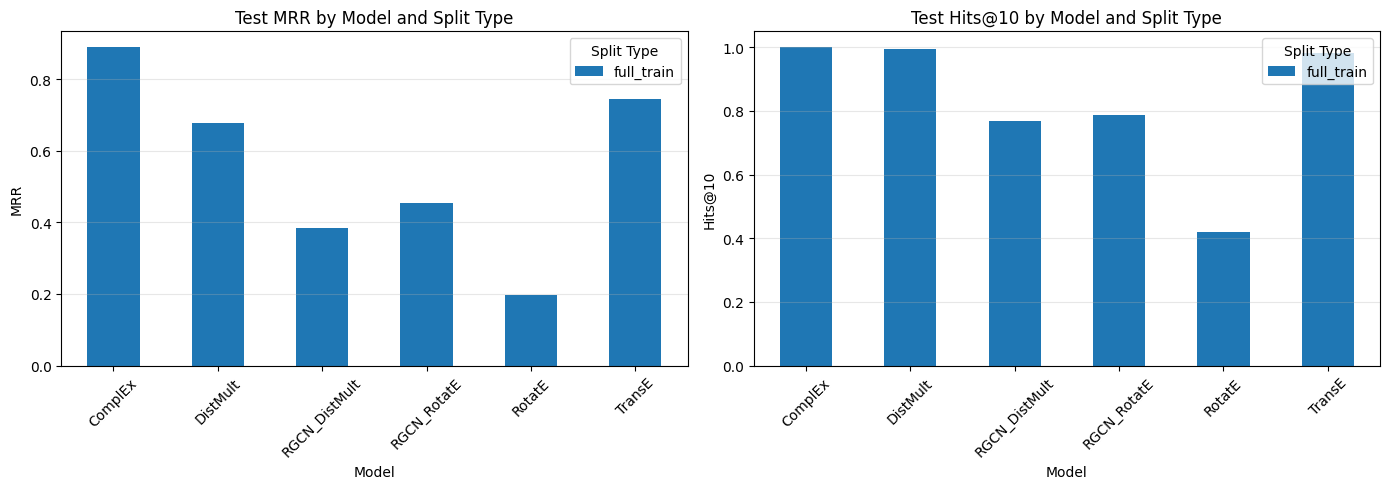

Figure saved to outputs/results/model_comparison.png


In [ ]:
# Plot MRR comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MRR comparison
ax = axes[0]
pivot_mrr.plot(kind='bar', ax=ax, rot=45)
ax.set_title('Test MRR by Model and Split Type', fontsize=12)
ax.set_xlabel('Model')
ax.set_ylabel('MRR')
ax.legend(title='Split Type', loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Hits@10 comparison
ax = axes[1]
pivot_hits10.plot(kind='bar', ax=ax, rot=45)
ax.set_title('Test Hits@10 by Model and Split Type', fontsize=12)
ax.set_xlabel('Model')
ax.set_ylabel('Hits@10')
ax.legend(title='Split Type', loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved to {output_dir}/model_comparison.png")

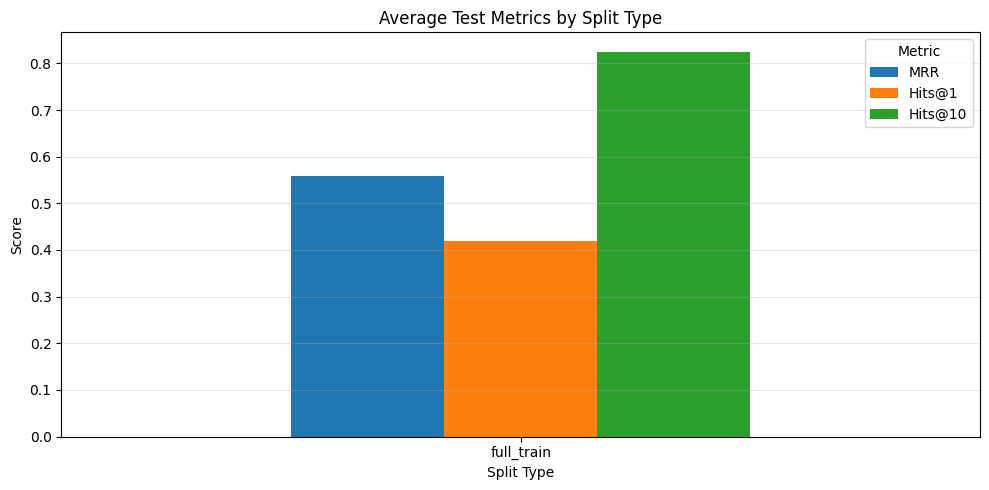

Figure saved to outputs/results/split_comparison.png


In [ ]:
# Split type comparison (average across models)
fig, ax = plt.subplots(figsize=(10, 5))

split_avg = results_df.groupby('split_type')[['test_mrr', 'test_hits1', 'test_hits10']].mean()
# Use all available split types dynamically (sorted for consistency)
split_avg = split_avg.loc[sorted(split_avg.index)]
split_avg.columns = ['MRR', 'Hits@1', 'Hits@10']

split_avg.plot(kind='bar', ax=ax, rot=0)
ax.set_title('Average Test Metrics by Split Type', fontsize=12)
ax.set_xlabel('Split Type')
ax.set_ylabel('Score')
ax.legend(title='Metric', loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/split_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved to {output_dir}/split_comparison.png")

## 8. Analysis and Observations

### Split Type Analysis

#### Type 1: Naive Random Split
- **Method**: Simple random 80/20 split. Vocabulary built only from training set.
- **Risk**: Validation/test may contain entities not in training vocabulary (inductive risk).
- **Observation**: Performance may suffer if many test entities are unseen.

#### Type 2: Transductive Split
- **Method**: Random 80/20 split with vocabulary from train + valid union.
- **Advantage**: All entities in valid are in vocabulary.
- **Observation**: Typically shows better valid performance than Type 1.

#### Type 3: Inverse Leakage Removal
- **Method**: Groups inverse relation pairs and splits by groups.
- **Purpose**: Prevents trivial leakage from inverse relations (e.g., fatherOf ↔ sonOf).
- **Observation**: Most reliable estimate of true generalization. Often shows lower scores.

### Model Comparison

| Model | Type | Characteristics |
|-------|------|----------------|
| TransE | Translation | Simple, struggles with symmetric/1-N relations |
| DistMult | Bilinear | Good for symmetric relations, struggles with asymmetric |
| ComplEx | Complex | Handles asymmetric relations via complex embeddings |
| RotatE | Rotation | Best for complex relation patterns |
| RGCN+DistMult | GNN | Structure-aware, but symmetric decoder |
| RGCN+RotatE | GNN | Structure-aware with asymmetric decoder |

### Key Findings

1. **Inverse Leakage Effect**: Compare Type 2 vs Type 3 to see how much performance comes from inverse relation shortcuts.

2. **Model Robustness**: Models performing well on Type 3 are learning genuine patterns.

3. **GNN Benefits**: RGCN models may show improved performance on sparse entities due to message passing.

4. **Test Generalization**: Test.txt results show how well models generalize to held-out data.

In [9]:
# Final summary statistics
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

# Best model per split type
print("\nBest Model per Split Type (by Test MRR):")
for split_type in split_types:
    split_results = results_df[results_df['split_type'] == split_type]
    best_idx = split_results['test_mrr'].idxmax()
    best = split_results.loc[best_idx]
    print(f"  {split_type}: {best['model']} (MRR={best['test_mrr']:.4f}, H@10={best['test_hits10']:.4f})")

# Best overall model
print("\nBest Overall Model (averaged across splits):")
model_avg = results_df.groupby('model')['test_mrr'].mean().sort_values(ascending=False)
print(f"  {model_avg.index[0]} (avg MRR={model_avg.iloc[0]:.4f})")

# Leakage analysis
print("\nInverse Leakage Analysis:")
trans_mrr = results_df[results_df['split_type'] == 'transductive']['test_mrr'].mean()
inverse_mrr = results_df[results_df['split_type'] == 'inverse_leakage_removal']['test_mrr'].mean()
leakage_drop = (trans_mrr - inverse_mrr) / trans_mrr * 100 if trans_mrr > 0 else 0
print(f"  Transductive avg MRR: {trans_mrr:.4f}")
print(f"  Inverse-removed avg MRR: {inverse_mrr:.4f}")
print(f"  Performance drop: {leakage_drop:.1f}%")
print(f"  NOTE: Large drop suggests models were exploiting inverse relation shortcuts")


FINAL SUMMARY

Best Model per Split Type (by Test MRR):


NameError: name 'results_df' is not defined

## 9. Custom vs Library (PyKEEN) Comparison

Direct comparison of our custom-built KGE models against PyKEEN library implementations.
Same architectures (TransE, DistMult, ComplEx, RotatE), same hyperparameters, same data splits.

**What this shows:**
- Whether our custom implementations are competitive with established libraries
- Impact of implementation details (loss functions, negative sampling, initialization)
- Consistency of results across different codebases

In [10]:
# ===== Combine custom and PyKEEN results =====
custom_df = pd.DataFrame(all_results)
custom_df['source'] = 'Custom'
custom_df['base_model'] = custom_df['model']  # TransE, DistMult, etc.

pykeen_df = pd.DataFrame(pykeen_all_results)
pykeen_df['source'] = 'PyKEEN'
pykeen_df['base_model'] = pykeen_df['model'].str.replace('PyKEEN_', '', regex=False)

combined_df = pd.concat([custom_df, pykeen_df], ignore_index=True)

# ===== Side-by-side MRR comparison table =====
kge_names = ['TransE', 'DistMult', 'ComplEx', 'RotatE']
comparison_rows = []
for st in split_types:
    for m in kge_names:
        c_mrr = custom_df[(custom_df['split_type'] == st) & (custom_df['base_model'] == m)]['test_mrr'].values
        p_mrr = pykeen_df[(pykeen_df['split_type'] == st) & (pykeen_df['base_model'] == m)]['test_mrr'].values
        c_h10 = custom_df[(custom_df['split_type'] == st) & (custom_df['base_model'] == m)]['test_hits10'].values
        p_h10 = pykeen_df[(pykeen_df['split_type'] == st) & (pykeen_df['base_model'] == m)]['test_hits10'].values
        comparison_rows.append({
            'Split': st,
            'Model': m,
            'Custom_MRR': c_mrr[0] if len(c_mrr) else np.nan,
            'PyKEEN_MRR': p_mrr[0] if len(p_mrr) else np.nan,
            'Custom_H@10': c_h10[0] if len(c_h10) else np.nan,
            'PyKEEN_H@10': p_h10[0] if len(p_h10) else np.nan,
        })

comp_df = pd.DataFrame(comparison_rows)
comp_df['MRR_Diff'] = comp_df['Custom_MRR'] - comp_df['PyKEEN_MRR']
comp_df['H@10_Diff'] = comp_df['Custom_H@10'] - comp_df['PyKEEN_H@10']

print("=" * 100)
print("CUSTOM vs PyKEEN: FULL COMPARISON TABLE")
print("=" * 100)
print(comp_df.to_string(index=False, float_format='%.4f'))

# ===== Winner count =====
custom_wins_mrr = (comp_df['MRR_Diff'] > 0).sum()
pykeen_wins_mrr = (comp_df['MRR_Diff'] < 0).sum()
ties_mrr = (comp_df['MRR_Diff'] == 0).sum()
print(f"\nMRR Winners: Custom={custom_wins_mrr}, PyKEEN={pykeen_wins_mrr}, Ties={ties_mrr}")

# ===== BAR CHARTS: Custom vs PyKEEN per split type =====
n_splits = len(split_types)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes_flat = axes.flatten()

for idx, st in enumerate(split_types[:4]):
    ax = axes_flat[idx]
    split_data = comp_df[comp_df['Split'] == st]
    x = np.arange(len(kge_names))
    width = 0.35
    ax.bar(x - width/2, split_data['Custom_MRR'].values, width, label='Custom', color='steelblue')
    ax.bar(x + width/2, split_data['PyKEEN_MRR'].values, width, label='PyKEEN', color='coral')
    ax.set_title(f'{st}', fontsize=12)
    ax.set_ylabel('Test MRR')
    ax.set_xticks(x)
    ax.set_xticklabels(kge_names, rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Handle case with fewer than 4 split types
for idx in range(len(split_types), 4):
    axes_flat[idx].set_visible(False)

plt.suptitle('Custom vs PyKEEN: Test MRR by Model and Split Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}/custom_vs_pykeen_mrr.png', dpi=150, bbox_inches='tight')
plt.show()

# ===== AGGREGATE COMPARISON =====
print("\n" + "=" * 80)
print("AVERAGE TEST MRR: CUSTOM vs PyKEEN (KGE models only)")
print("=" * 80)

# Per model average across splits
avg_custom = custom_df[custom_df['base_model'].isin(kge_names)].groupby('base_model')[['test_mrr', 'test_hits10']].mean()
avg_pykeen = pykeen_df.groupby('base_model')[['test_mrr', 'test_hits10']].mean()
summary = pd.DataFrame({
    'Custom_MRR': avg_custom['test_mrr'],
    'PyKEEN_MRR': avg_pykeen['test_mrr'],
    'Custom_H@10': avg_custom['test_hits10'],
    'PyKEEN_H@10': avg_pykeen['test_hits10'],
})
summary['MRR_Diff'] = summary['Custom_MRR'] - summary['PyKEEN_MRR']
print(summary.round(4))

# Per split average across models
print("\n" + "=" * 80)
print("AVERAGE TEST MRR BY SPLIT TYPE")
print("=" * 80)
split_custom = custom_df[custom_df['base_model'].isin(kge_names)].groupby('split_type')['test_mrr'].mean()
split_pykeen = pykeen_df.groupby('split_type')['test_mrr'].mean()
split_summary = pd.DataFrame({'Custom': split_custom, 'PyKEEN': split_pykeen})
split_summary['Difference'] = split_summary['Custom'] - split_summary['PyKEEN']
print(split_summary.round(4))

# Overall
print(f"\nOverall Custom avg MRR:  {avg_custom['test_mrr'].mean():.4f}")
print(f"Overall PyKEEN avg MRR:  {avg_pykeen['test_mrr'].mean():.4f}")
print(f"Overall Custom avg H@10: {avg_custom['test_hits10'].mean():.4f}")
print(f"Overall PyKEEN avg H@10: {avg_pykeen['test_hits10'].mean():.4f}")

# ===== GROUPED BAR: Average across splits =====
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(kge_names))
width = 0.35
ax.bar(x - width/2, summary['Custom_MRR'].values, width, label='Custom', color='steelblue')
ax.bar(x + width/2, summary['PyKEEN_MRR'].values, width, label='PyKEEN', color='coral')
ax.set_title('Average Test MRR: Custom vs PyKEEN (across all splits)', fontsize=12)
ax.set_ylabel('Test MRR')
ax.set_xticks(x)
ax.set_xticklabels(summary.index)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/custom_vs_pykeen_avg.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigures saved to {output_dir}/")

NameError: name 'all_results' is not defined

In [ ]:
# ===== COMPLETE RESULTS: All models (Custom + PyKEEN + GNN) =====
print("=" * 100)
print("COMPLETE RESULTS: ALL MODELS x ALL SPLITS")
print("=" * 100)

# Include GNN models in the custom results
full_combined = pd.concat([custom_df, pykeen_df], ignore_index=True)
print(full_combined[['split_type', 'model', 'source', 'test_mrr', 'test_hits1', 'test_hits10']].to_string(index=False, float_format='%.4f'))

# Save combined results
full_combined.to_csv(f'{output_dir}/all_results_combined.csv', index=False)
print(f"\nCombined results saved to {output_dir}/all_results_combined.csv")

# ===== BEST MODEL OVERALL =====
print("\n" + "=" * 80)
print("BEST MODEL PER SPLIT TYPE (across Custom + PyKEEN)")
print("=" * 80)
for st in split_types:
    st_df = full_combined[full_combined['split_type'] == st]
    best = st_df.loc[st_df['test_mrr'].idxmax()]
    print(f"  {st}: {best['model']} [{best['source']}] (MRR={best['test_mrr']:.4f}, H@10={best['test_hits10']:.4f})")

print("\nBest Overall (avg across splits):")
overall = full_combined.groupby(['model', 'source'])['test_mrr'].mean().sort_values(ascending=False)
best_name, best_source = overall.index[0]
print(f"  {best_name} [{best_source}] (avg MRR={overall.iloc[0]:.4f})")